Import useful packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import math
import operator
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Camera Calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

Define functions that will be used in the pipeline

In [3]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [4]:
def perspective_transform(img,src,dst):
    img_size = (img.shape[1], img.shape[0])
   # src = vertices
   #offset = 150 # offset for dst points
   # dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])  
   # dst = np.float32([[450, img.shape[0]], [450, 0], [img.shape[1]-450,0], [img.shape[1]-450, img.shape[0]]]) 
   # dst = np.float32([[200, 720], [200, 0], [1000,0], [1000, 720]]) 
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)    
    return warped, M, Minv

In [5]:
def threshold_binary(img, sx_thresh=(20, 100), s_thresh=(170, 225)):
    #Convert to HLS color space and separate the S channel
    #Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    #thresh_min = 20
    #thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1


    # Threshold color channel
    #s_thresh_min = 170
    #s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

Show Undistorted image after calibrating the camera

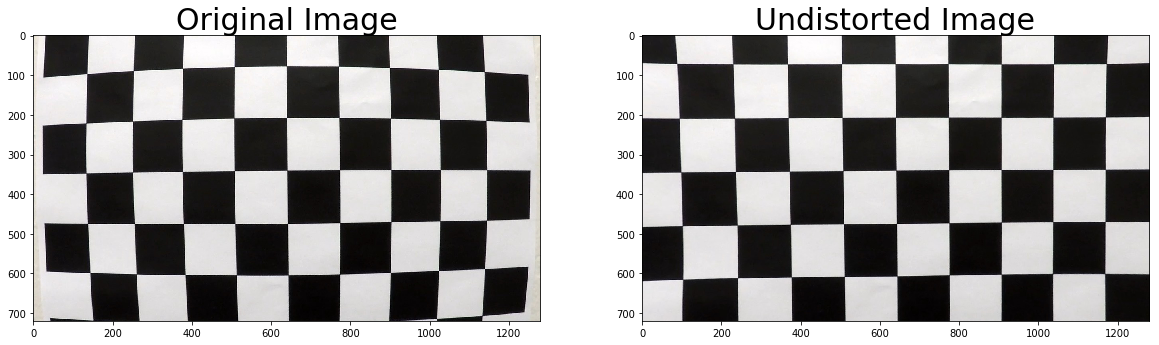

In [6]:
img = mpimg.imread('camera_cal/calibration1.jpg')
img_undistort = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistort)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_image.jpg')

Show all the steps in the pipeline on a test image

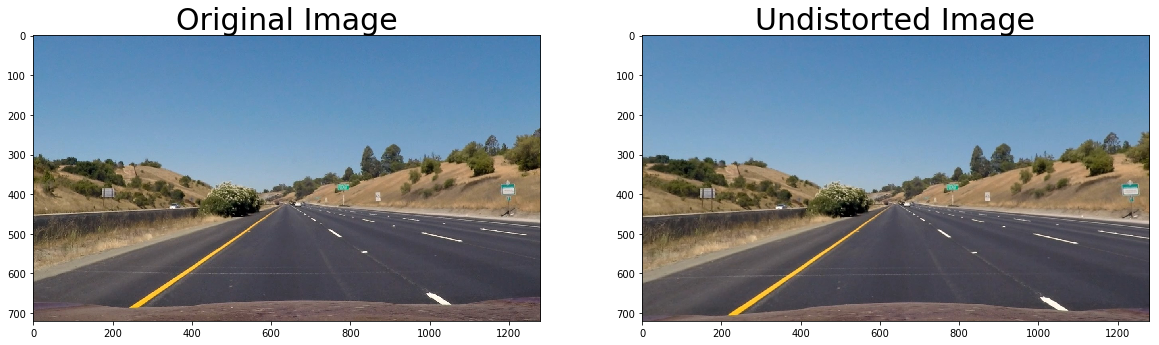

In [7]:
img = mpimg.imread('test_images/straight_lines1.jpg')

d = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(d)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistorted_test_image.jpg')

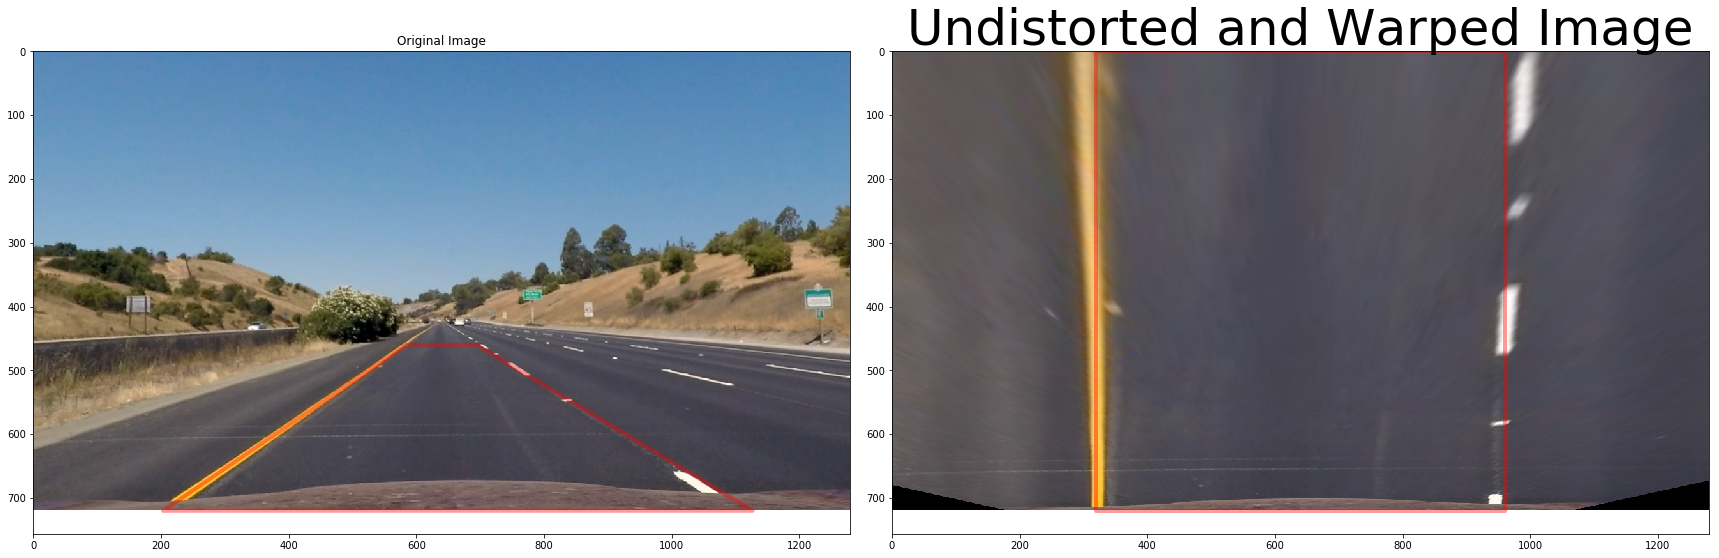

In [8]:
top_y_vertex = 480
#src = np.float32([[200,700],[500, top_y_vertex], [750, top_y_vertex], [1100,700]])
#dst = np.float32([[200, 720], [200, 0], [1000,0], [1000, 720]])

src = np.float32([[585, 460], [695, 460],[203,720],[1127,720]])
dst = np.float32([[320, 0],[960,0],[320, 720],[960, 720]])

pt, M, Minv = perspective_transform(d,src,dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(d)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='r', alpha=0.4, linewidth=4, solid_capstyle='round', zorder=2)
ax1.set_title('Original Image')
ax2.imshow(pt, cmap = 'gray')
x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x, y, color='r', alpha=0.4, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.savefig('output_images/warped_test_image.jpg')

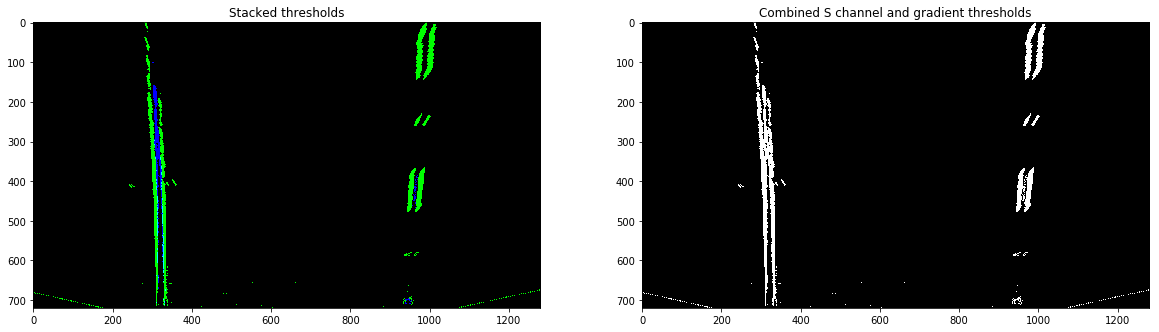

In [9]:
color_binary,combined_binary = threshold_binary(pt)
#Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)
ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.savefig('output_images/thresholded_binary_test_image.jpg')

Obtain a histogram of the lower half of the image to detect where the lane lines are located

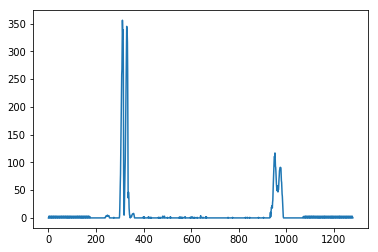

In [10]:
img = combined_binary
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/historgram.jpg')

Function to fit a second order polynomial to each sliding window from the bottom of the image to top

In [11]:
def sliding_window_fit(binary_warped): 
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

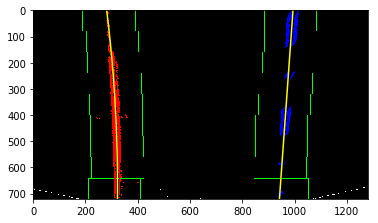

In [12]:
left_fit, right_fit, left_lane_inds, right_lane_inds,out_img = sliding_window_fit(combined_binary)
# Generate x and y values for plotting
binary_warped = combined_binary
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/fit_polynomial.jpg')

In [13]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def polyfit_using_prev_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, left_lane_inds, right_lane_inds

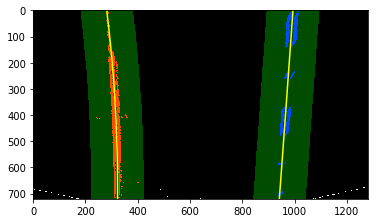

In [14]:
left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = polyfit_using_prev_fit(combined_binary, left_fit, right_fit)

binary_warped = combined_binary
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100

#Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx2 = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/fit_polynomial_2.jpg')

Radius of Curvature and position of vehicle calculation

In [34]:
def curvature(combined_binary, left_fit, right_fit, left_lane_inds, right_lane_inds):
    h = combined_binary.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    
    car_position = combined_binary.shape[1]/2
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [35]:
rad_left, rad_right, d_center = curvature(combined_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_left, 'm,', rad_right, 'm')
print('Distance from lane center for example:', d_center, 'm')

2027.40901747 m 344731.830235 m
Radius of curvature for example: 2027.40901747 m, 344731.830235 m
Distance from lane center for example: 0.035836568313 m


Draw Lane on the original image

In [36]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

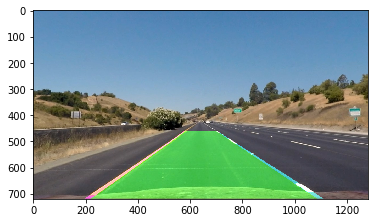

In [37]:
dl_img = draw_lane(d, combined_binary, left_fit, right_fit, Minv)
plt.imshow(dl_img)
plt.savefig('output_images/Lanes_drawn.jpg')

In [38]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


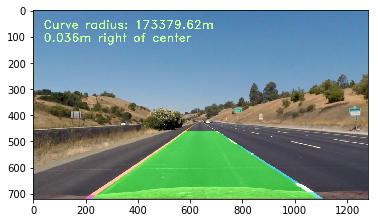

In [39]:
dd_img = draw_data(dl_img, (rad_left+rad_right)/2, d_center)
plt.imshow(dd_img)
print('...')
plt.savefig('output_images/Lanes_drawn_with_data.jpg')

Define a class to receive the characteristics of each line detection

In [40]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

print('...')


...


Function to process each frame of the video with all the above steps

In [41]:
def process_image(img):
    new_img = np.copy(img)
    d = undistort(new_img)
    
    top_y_vertex = 480
    #src = np.float32([[200,700],[500, top_y_vertex], [750, top_y_vertex], [1100,700]])
    #dst = np.float32([[200, 720], [200, 0], [1000,0], [1000, 720]])
    
    src = np.float32([[203,720],[585, 460],[695, 460],[1127,720]])
    dst = np.float32([[200, 720], [200, 0], [1000,0], [1000, 720]]) 
    
    pt, M, Minv = perspective_transform(d,src,dst)

    color_binary,combined_binary = threshold_binary(pt)

    img_bin = combined_binary
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_fit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(750 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = curvature(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


In [42]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...


In [43]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output_final.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

633.580915884 m 911.650404022 m
[MoviePy] >>>> Building video project_video_output_final.mp4
[MoviePy] Writing video project_video_output_final.mp4


  0%|          | 1/1261 [00:00<14:48,  1.42it/s]

660.484632742 m 873.575391954 m


  0%|          | 2/1261 [00:01<14:47,  1.42it/s]

659.087786671 m 983.623546357 m


  0%|          | 3/1261 [00:02<14:44,  1.42it/s]

619.564922871 m 676.23963395 m


  0%|          | 4/1261 [00:02<14:38,  1.43it/s]

589.936495189 m 634.937046021 m


  0%|          | 5/1261 [00:03<15:06,  1.39it/s]

610.792228209 m 643.268303432 m


  0%|          | 6/1261 [00:04<15:31,  1.35it/s]

604.330838456 m 746.440706628 m


  1%|          | 7/1261 [00:05<15:24,  1.36it/s]

659.497602407 m 863.953861985 m


  1%|          | 8/1261 [00:05<15:15,  1.37it/s]

691.959027042 m 2119.73488038 m


  1%|          | 9/1261 [00:06<15:02,  1.39it/s]

755.758430543 m 4510.92952633 m


  1%|          | 10/1261 [00:07<15:00,  1.39it/s]

782.717863936 m 4745.44704868 m


  1%|          | 11/1261 [00:08<15:26,  1.35it/s]

803.335839647 m 9385.22303593 m


  1%|          | 12/1261 [00:08<15:53,  1.31it/s]

923.519321666 m 7818.28140196 m


  1%|          | 13/1261 [00:09<15:53,  1.31it/s]

1102.87693595 m 8876.89515918 m


  1%|          | 14/1261 [00:10<15:27,  1.34it/s]

1100.87813407 m 6976.24104025 m


  1%|          | 15/1261 [00:10<15:10,  1.37it/s]

1110.15929633 m 1418.00169376 m


  1%|▏         | 16/1261 [00:11<15:11,  1.37it/s]

1135.75266176 m 991.864237321 m


  1%|▏         | 17/1261 [00:12<14:42,  1.41it/s]

1116.43943207 m 934.021229983 m


  1%|▏         | 18/1261 [00:13<14:28,  1.43it/s]

1221.73769676 m 1042.7235129 m


  2%|▏         | 19/1261 [00:13<14:20,  1.44it/s]

1176.74225505 m 1079.54850927 m


  2%|▏         | 20/1261 [00:14<14:20,  1.44it/s]

1330.47427136 m 1183.87726669 m


  2%|▏         | 21/1261 [00:15<14:07,  1.46it/s]

1523.89332498 m 1326.1501138 m


  2%|▏         | 22/1261 [00:15<14:01,  1.47it/s]

1423.72781843 m 1434.84286326 m


  2%|▏         | 23/1261 [00:16<14:07,  1.46it/s]

1429.90916826 m 1526.35521611 m


  2%|▏         | 24/1261 [00:17<14:10,  1.45it/s]

1247.56198918 m 1372.18695285 m


  2%|▏         | 25/1261 [00:17<14:53,  1.38it/s]

1013.99672973 m 1223.24757944 m


  2%|▏         | 26/1261 [00:18<15:45,  1.31it/s]

1002.14948765 m 1220.99410147 m


  2%|▏         | 27/1261 [00:19<15:40,  1.31it/s]

917.132233442 m 1097.39940469 m


  2%|▏         | 28/1261 [00:20<15:08,  1.36it/s]

908.479666861 m 1333.7172965 m


  2%|▏         | 29/1261 [00:21<15:25,  1.33it/s]

855.402972211 m 1229.61741086 m


  2%|▏         | 30/1261 [00:21<15:46,  1.30it/s]

763.883942811 m 686.890005344 m


  2%|▏         | 31/1261 [00:22<15:19,  1.34it/s]

755.170404326 m 697.934844533 m


  3%|▎         | 32/1261 [00:23<15:17,  1.34it/s]

649.043919951 m 684.47531656 m


  3%|▎         | 33/1261 [00:24<15:13,  1.34it/s]

676.121974204 m 778.638016173 m


  3%|▎         | 34/1261 [00:24<14:57,  1.37it/s]

651.686624392 m 796.449466489 m


  3%|▎         | 35/1261 [00:25<15:19,  1.33it/s]

618.605160101 m 783.082682005 m


  3%|▎         | 36/1261 [00:26<15:26,  1.32it/s]

581.276734601 m 737.288700705 m


  3%|▎         | 37/1261 [00:27<15:18,  1.33it/s]

525.274382066 m 754.684149069 m


  3%|▎         | 38/1261 [00:27<15:05,  1.35it/s]

495.176267946 m 794.330697224 m


  3%|▎         | 39/1261 [00:28<14:58,  1.36it/s]

470.648290092 m 597.861148391 m


  3%|▎         | 40/1261 [00:29<14:59,  1.36it/s]

480.521093718 m 537.145387275 m


  3%|▎         | 41/1261 [00:29<14:59,  1.36it/s]

465.567302852 m 578.784252571 m


  3%|▎         | 42/1261 [00:30<14:47,  1.37it/s]

463.877477678 m 686.73598893 m


  3%|▎         | 43/1261 [00:31<15:42,  1.29it/s]

486.325622463 m 612.736371508 m


  3%|▎         | 44/1261 [00:32<15:28,  1.31it/s]

500.517914422 m 610.463073312 m


  4%|▎         | 45/1261 [00:33<15:15,  1.33it/s]

525.549452609 m 603.6156078 m


  4%|▎         | 46/1261 [00:33<15:11,  1.33it/s]

556.155820996 m 705.555593687 m


  4%|▎         | 47/1261 [00:34<15:10,  1.33it/s]

595.464851674 m 612.563222953 m


  4%|▍         | 48/1261 [00:35<15:11,  1.33it/s]

600.64345479 m 723.710129058 m


  4%|▍         | 49/1261 [00:35<15:06,  1.34it/s]

664.087809198 m 821.634784317 m


  4%|▍         | 50/1261 [00:36<14:47,  1.36it/s]

706.112174314 m 752.215993079 m


  4%|▍         | 51/1261 [00:37<14:32,  1.39it/s]

782.835539801 m 776.697265221 m


  4%|▍         | 52/1261 [00:38<14:35,  1.38it/s]

842.904891823 m 844.445154001 m


  4%|▍         | 53/1261 [00:38<15:15,  1.32it/s]

914.178560974 m 645.829888407 m


  4%|▍         | 54/1261 [00:39<14:53,  1.35it/s]

992.051603638 m 601.737237917 m


  4%|▍         | 55/1261 [00:40<14:43,  1.37it/s]

1103.06879162 m 562.038827739 m


  4%|▍         | 56/1261 [00:41<14:26,  1.39it/s]

1221.91101615 m 594.924457406 m


  5%|▍         | 57/1261 [00:41<14:31,  1.38it/s]

1252.7247884 m 665.318318001 m


  5%|▍         | 58/1261 [00:42<14:15,  1.41it/s]

1281.14905413 m 805.690563692 m


  5%|▍         | 59/1261 [00:43<14:17,  1.40it/s]

1033.81746034 m 623.402528037 m


  5%|▍         | 60/1261 [00:43<14:11,  1.41it/s]

955.706387863 m 978.511085413 m


  5%|▍         | 61/1261 [00:44<14:17,  1.40it/s]

889.542674587 m 1230.86617405 m


  5%|▍         | 62/1261 [00:45<16:00,  1.25it/s]

788.816197166 m 1044.59788663 m


  5%|▍         | 63/1261 [00:46<15:53,  1.26it/s]

782.23906839 m 1869.18160637 m


  5%|▌         | 64/1261 [00:47<15:16,  1.31it/s]

750.244813368 m 661.890455364 m


  5%|▌         | 65/1261 [00:47<14:51,  1.34it/s]

760.556934763 m 749.593308331 m


  5%|▌         | 66/1261 [00:48<14:26,  1.38it/s]

683.137436184 m 856.122546086 m


  5%|▌         | 67/1261 [00:49<14:16,  1.39it/s]

604.817002318 m 894.507271834 m


  5%|▌         | 68/1261 [00:49<14:25,  1.38it/s]

696.585125989 m 929.682485279 m


  5%|▌         | 69/1261 [00:50<14:25,  1.38it/s]

676.00322837 m 924.849166154 m


  6%|▌         | 70/1261 [00:51<16:36,  1.19it/s]

774.834091263 m 984.855298422 m


  6%|▌         | 71/1261 [00:52<16:10,  1.23it/s]

979.275206583 m 926.219678296 m


  6%|▌         | 72/1261 [00:53<15:39,  1.27it/s]

1094.69262631 m 855.212991141 m


  6%|▌         | 73/1261 [00:53<15:10,  1.30it/s]

1158.47200577 m 727.214162602 m


  6%|▌         | 74/1261 [00:54<14:53,  1.33it/s]

1245.84371786 m 769.837898227 m


  6%|▌         | 75/1261 [00:55<14:27,  1.37it/s]

1334.43543111 m 842.382975742 m


  6%|▌         | 76/1261 [00:56<14:22,  1.37it/s]

1359.68130948 m 678.547500954 m


  6%|▌         | 77/1261 [00:56<14:37,  1.35it/s]

1628.87606113 m 884.451182204 m


  6%|▌         | 78/1261 [00:57<16:07,  1.22it/s]

1754.55006805 m 795.924192959 m


  6%|▋         | 79/1261 [00:58<15:22,  1.28it/s]

1704.16570411 m 579.177360411 m


  6%|▋         | 80/1261 [00:59<14:48,  1.33it/s]

1483.86838143 m 601.412885414 m


  6%|▋         | 81/1261 [00:59<14:15,  1.38it/s]

1886.50213448 m 614.372234247 m


  7%|▋         | 82/1261 [01:00<13:54,  1.41it/s]

1762.79550169 m 619.44819146 m


  7%|▋         | 83/1261 [01:01<13:38,  1.44it/s]

1523.67269577 m 707.994703497 m


  7%|▋         | 84/1261 [01:01<13:29,  1.45it/s]

2068.54628197 m 774.498605514 m


  7%|▋         | 85/1261 [01:02<13:20,  1.47it/s]

1857.56748703 m 969.0201888 m


  7%|▋         | 86/1261 [01:03<13:13,  1.48it/s]

1390.17086154 m 1040.38208323 m


  7%|▋         | 87/1261 [01:03<13:09,  1.49it/s]

1051.46589487 m 900.289253053 m


  7%|▋         | 88/1261 [01:04<13:14,  1.48it/s]

892.24718727 m 1144.98873444 m


  7%|▋         | 89/1261 [01:05<13:16,  1.47it/s]

777.325022103 m 1050.19626915 m


  7%|▋         | 90/1261 [01:05<13:20,  1.46it/s]

685.862119269 m 682.416617752 m


  7%|▋         | 91/1261 [01:06<14:16,  1.37it/s]

666.213023531 m 692.174724676 m


  7%|▋         | 92/1261 [01:07<14:29,  1.34it/s]

695.824121323 m 736.179953328 m


  7%|▋         | 93/1261 [01:08<14:17,  1.36it/s]

756.433794774 m 731.131429927 m


  7%|▋         | 94/1261 [01:09<15:06,  1.29it/s]

775.205889599 m 758.28915765 m


  8%|▊         | 95/1261 [01:09<14:55,  1.30it/s]

832.374123096 m 814.817840346 m


  8%|▊         | 96/1261 [01:10<14:26,  1.34it/s]

998.116688804 m 900.29307192 m


  8%|▊         | 97/1261 [01:11<14:04,  1.38it/s]

950.379751243 m 902.943549963 m


  8%|▊         | 98/1261 [01:12<15:05,  1.28it/s]

952.738993669 m 957.911435493 m


  8%|▊         | 99/1261 [01:13<15:47,  1.23it/s]

950.599363033 m 936.367139616 m


  8%|▊         | 100/1261 [01:13<16:14,  1.19it/s]

912.736197531 m 838.309128303 m


  8%|▊         | 101/1261 [01:14<15:40,  1.23it/s]

910.585019919 m 845.783320866 m


  8%|▊         | 102/1261 [01:15<15:15,  1.27it/s]

843.679479663 m 811.899472673 m


  8%|▊         | 103/1261 [01:16<15:59,  1.21it/s]

750.986468364 m 613.503282505 m


  8%|▊         | 104/1261 [01:17<15:11,  1.27it/s]

725.257299723 m 642.013597726 m


  8%|▊         | 105/1261 [01:17<14:42,  1.31it/s]

716.652459886 m 656.540838006 m


  8%|▊         | 106/1261 [01:18<14:11,  1.36it/s]

747.029402934 m 660.474005437 m


  8%|▊         | 107/1261 [01:19<13:49,  1.39it/s]

757.089182095 m 692.832794964 m


  9%|▊         | 108/1261 [01:19<13:36,  1.41it/s]

739.652022778 m 702.208138772 m


  9%|▊         | 109/1261 [01:20<13:25,  1.43it/s]

850.947016655 m 987.369386957 m


  9%|▊         | 110/1261 [01:21<14:33,  1.32it/s]

843.601403964 m 958.771477327 m


  9%|▉         | 111/1261 [01:22<14:42,  1.30it/s]

795.618039423 m 1217.27077554 m


  9%|▉         | 112/1261 [01:22<14:42,  1.30it/s]

839.983223976 m 967.299487857 m


  9%|▉         | 113/1261 [01:23<14:10,  1.35it/s]

773.03364848 m 817.522403355 m


  9%|▉         | 114/1261 [01:24<14:01,  1.36it/s]

770.636422334 m 759.358885149 m


  9%|▉         | 115/1261 [01:25<13:45,  1.39it/s]

668.465894378 m 731.632703299 m


  9%|▉         | 116/1261 [01:25<13:29,  1.42it/s]

641.301213415 m 493.069047519 m


  9%|▉         | 117/1261 [01:26<13:17,  1.43it/s]

629.993935653 m 551.08798073 m


  9%|▉         | 118/1261 [01:27<13:07,  1.45it/s]

619.957273494 m 535.324271835 m


  9%|▉         | 119/1261 [01:27<13:00,  1.46it/s]

597.975317719 m 533.176640224 m


 10%|▉         | 120/1261 [01:28<12:55,  1.47it/s]

562.284419671 m 550.101597888 m


 10%|▉         | 121/1261 [01:29<13:03,  1.46it/s]

571.798777811 m 553.522041362 m


 10%|▉         | 122/1261 [01:29<13:05,  1.45it/s]

617.032467082 m 525.004528301 m


 10%|▉         | 123/1261 [01:30<13:08,  1.44it/s]

582.596098848 m 512.232482688 m


 10%|▉         | 124/1261 [01:31<13:08,  1.44it/s]

576.166039451 m 639.91119916 m


 10%|▉         | 125/1261 [01:31<13:29,  1.40it/s]

548.522130598 m 775.269901245 m


 10%|▉         | 126/1261 [01:32<13:45,  1.37it/s]

613.31691353 m 779.243653529 m


 10%|█         | 127/1261 [01:33<13:56,  1.36it/s]

601.939180188 m 511.711370735 m


 10%|█         | 128/1261 [01:34<13:42,  1.38it/s]

644.128094734 m 526.507878342 m


 10%|█         | 129/1261 [01:34<13:32,  1.39it/s]

629.885740274 m 501.704653964 m


 10%|█         | 130/1261 [01:35<13:18,  1.42it/s]

687.557751303 m 548.339256455 m


 10%|█         | 131/1261 [01:36<13:35,  1.39it/s]

763.554521915 m 541.78913829 m


 10%|█         | 132/1261 [01:37<13:54,  1.35it/s]

743.568489878 m 507.344718931 m


 11%|█         | 133/1261 [01:37<13:57,  1.35it/s]

757.182954133 m 465.341656047 m


 11%|█         | 134/1261 [01:38<13:50,  1.36it/s]

786.83863654 m 459.297726115 m


 11%|█         | 135/1261 [01:39<13:33,  1.38it/s]

808.140449029 m 442.500303003 m


 11%|█         | 136/1261 [01:39<13:18,  1.41it/s]

834.236206864 m 508.610891381 m


 11%|█         | 137/1261 [01:40<13:19,  1.41it/s]

815.682243515 m 651.05494161 m


 11%|█         | 138/1261 [01:41<13:29,  1.39it/s]

830.575337226 m 801.718653304 m


 11%|█         | 139/1261 [01:42<13:13,  1.41it/s]

845.249337265 m 791.394554467 m


 11%|█         | 140/1261 [01:42<12:58,  1.44it/s]

861.63765949 m 893.944275595 m


 11%|█         | 141/1261 [01:43<12:49,  1.46it/s]

863.17473782 m 753.349705835 m


 11%|█▏        | 142/1261 [01:44<12:47,  1.46it/s]

892.879215065 m 757.222179993 m


 11%|█▏        | 143/1261 [01:44<13:01,  1.43it/s]

905.108926794 m 818.375874285 m


 11%|█▏        | 144/1261 [01:45<13:28,  1.38it/s]

960.038419443 m 818.79901679 m


 11%|█▏        | 145/1261 [01:46<13:43,  1.35it/s]

1000.08056368 m 874.802228698 m


 12%|█▏        | 146/1261 [01:47<13:39,  1.36it/s]

944.309162543 m 836.717322555 m


 12%|█▏        | 147/1261 [01:47<13:26,  1.38it/s]

1202.2924037 m 704.676843105 m


 12%|█▏        | 148/1261 [01:48<13:20,  1.39it/s]

1013.20634167 m 723.513538208 m


 12%|█▏        | 149/1261 [01:49<13:12,  1.40it/s]

990.782602446 m 711.207664944 m


 12%|█▏        | 150/1261 [01:49<13:14,  1.40it/s]

993.030044204 m 825.522597408 m


 12%|█▏        | 151/1261 [01:50<13:09,  1.41it/s]

1005.18698884 m 656.983867593 m


 12%|█▏        | 152/1261 [01:51<13:11,  1.40it/s]

1015.38093453 m 559.716164745 m


 12%|█▏        | 153/1261 [01:52<13:06,  1.41it/s]

868.883665209 m 566.729654408 m


 12%|█▏        | 154/1261 [01:52<13:10,  1.40it/s]

882.120272329 m 590.718207849 m


 12%|█▏        | 155/1261 [01:53<13:16,  1.39it/s]

926.35507175 m 616.816356403 m


 12%|█▏        | 156/1261 [01:54<13:09,  1.40it/s]

875.997330085 m 665.200976137 m


 12%|█▏        | 157/1261 [01:54<13:01,  1.41it/s]

840.529344848 m 710.189647213 m


 13%|█▎        | 158/1261 [01:55<13:03,  1.41it/s]

754.679292864 m 736.708576632 m


 13%|█▎        | 159/1261 [01:56<13:17,  1.38it/s]

817.005734208 m 675.648139516 m


 13%|█▎        | 160/1261 [01:57<13:28,  1.36it/s]

765.287275849 m 783.814429664 m


 13%|█▎        | 161/1261 [01:57<13:12,  1.39it/s]

785.36598522 m 1055.20230607 m


 13%|█▎        | 162/1261 [01:58<13:17,  1.38it/s]

726.951642992 m 1023.42032168 m


 13%|█▎        | 163/1261 [01:59<12:59,  1.41it/s]

714.88594229 m 1111.54214804 m


 13%|█▎        | 164/1261 [01:59<12:51,  1.42it/s]

693.178745809 m 1543.67419652 m


 13%|█▎        | 165/1261 [02:00<12:52,  1.42it/s]

758.716684075 m 638.096480263 m


 13%|█▎        | 166/1261 [02:01<12:45,  1.43it/s]

696.634344617 m 792.614920793 m


 13%|█▎        | 167/1261 [02:01<12:37,  1.44it/s]

701.408324615 m 666.511369797 m


 13%|█▎        | 168/1261 [02:02<12:37,  1.44it/s]

793.74474555 m 748.300551731 m


 13%|█▎        | 169/1261 [02:03<12:37,  1.44it/s]

877.941674768 m 681.076139725 m


 13%|█▎        | 170/1261 [02:04<12:38,  1.44it/s]

935.239453421 m 709.526673025 m


 14%|█▎        | 171/1261 [02:04<12:31,  1.45it/s]

1120.54575726 m 665.971119906 m


 14%|█▎        | 172/1261 [02:05<12:27,  1.46it/s]

1182.37200315 m 555.784117822 m


 14%|█▎        | 173/1261 [02:06<12:32,  1.45it/s]

1094.99707033 m 453.227245738 m


 14%|█▍        | 174/1261 [02:06<12:24,  1.46it/s]

976.320217968 m 411.666741886 m


 14%|█▍        | 175/1261 [02:07<12:19,  1.47it/s]

856.46374638 m 379.003209322 m


 14%|█▍        | 176/1261 [02:08<12:20,  1.47it/s]

837.865541524 m 298.905157674 m


 14%|█▍        | 177/1261 [02:08<12:15,  1.47it/s]

888.867135665 m 334.357822096 m


 14%|█▍        | 178/1261 [02:09<12:12,  1.48it/s]

872.721899379 m 341.826700192 m


 14%|█▍        | 179/1261 [02:10<12:05,  1.49it/s]

805.834893526 m 355.921113202 m


 14%|█▍        | 180/1261 [02:10<12:01,  1.50it/s]

769.4970935 m 364.042624773 m


 14%|█▍        | 181/1261 [02:11<11:55,  1.51it/s]

689.864152339 m 390.672414759 m


 14%|█▍        | 182/1261 [02:12<11:49,  1.52it/s]

684.082734178 m 395.402559289 m


 15%|█▍        | 183/1261 [02:12<11:48,  1.52it/s]

632.715158118 m 407.200875503 m


 15%|█▍        | 184/1261 [02:13<11:48,  1.52it/s]

568.679665054 m 463.022596684 m


 15%|█▍        | 185/1261 [02:14<11:53,  1.51it/s]

520.039007326 m 494.842285907 m


 15%|█▍        | 186/1261 [02:14<11:48,  1.52it/s]

447.704610715 m 391.838048547 m


 15%|█▍        | 187/1261 [02:15<11:45,  1.52it/s]

448.232764677 m 402.924242141 m


 15%|█▍        | 188/1261 [02:16<11:44,  1.52it/s]

459.567420352 m 413.10464571 m


 15%|█▍        | 189/1261 [02:16<11:48,  1.51it/s]

473.765934358 m 419.055858794 m


 15%|█▌        | 190/1261 [02:17<11:58,  1.49it/s]

483.031070897 m 469.044591136 m


 15%|█▌        | 191/1261 [02:18<12:10,  1.46it/s]

479.017931142 m 487.93811844 m


 15%|█▌        | 192/1261 [02:18<12:05,  1.47it/s]

527.00171894 m 493.272699273 m


 15%|█▌        | 193/1261 [02:19<12:05,  1.47it/s]

538.937714552 m 507.841835377 m


 15%|█▌        | 194/1261 [02:20<12:06,  1.47it/s]

570.940640045 m 507.123555522 m


 15%|█▌        | 195/1261 [02:20<12:02,  1.48it/s]

591.086936846 m 560.083368831 m


 16%|█▌        | 196/1261 [02:21<11:53,  1.49it/s]

713.367424951 m 638.644699999 m


 16%|█▌        | 197/1261 [02:22<11:45,  1.51it/s]

816.174981069 m 770.170068966 m


 16%|█▌        | 198/1261 [02:22<11:42,  1.51it/s]

958.290190546 m 553.394163806 m


 16%|█▌        | 199/1261 [02:23<11:39,  1.52it/s]

1144.93857922 m 570.450084675 m


 16%|█▌        | 200/1261 [02:24<11:38,  1.52it/s]

1169.20867644 m 1040.26237153 m


 16%|█▌        | 201/1261 [02:24<11:42,  1.51it/s]

1333.07818866 m 906.745416934 m


 16%|█▌        | 202/1261 [02:25<11:42,  1.51it/s]

1203.39445554 m 1005.79384683 m


 16%|█▌        | 203/1261 [02:26<11:43,  1.50it/s]

1059.29734751 m 875.91418895 m


 16%|█▌        | 204/1261 [02:26<11:49,  1.49it/s]

893.692125976 m 609.626176129 m


 16%|█▋        | 205/1261 [02:27<11:47,  1.49it/s]

785.291398026 m 616.978530715 m


 16%|█▋        | 206/1261 [02:28<11:48,  1.49it/s]

738.141810216 m 599.173018561 m


 16%|█▋        | 207/1261 [02:28<11:58,  1.47it/s]

631.728657732 m 549.065696283 m


 16%|█▋        | 208/1261 [02:29<11:54,  1.47it/s]

629.755945032 m 502.102194021 m


 17%|█▋        | 209/1261 [02:30<12:06,  1.45it/s]

641.308268105 m 541.490010474 m


 17%|█▋        | 210/1261 [02:30<11:55,  1.47it/s]

640.890800775 m 478.619184535 m


 17%|█▋        | 211/1261 [02:31<12:12,  1.43it/s]

711.445004483 m 433.047246173 m


 17%|█▋        | 212/1261 [02:32<12:18,  1.42it/s]

655.943930715 m 634.118923293 m


 17%|█▋        | 213/1261 [02:33<12:22,  1.41it/s]

637.477952791 m 692.985310442 m


 17%|█▋        | 214/1261 [02:33<12:16,  1.42it/s]

606.276417945 m 860.543314861 m


 17%|█▋        | 215/1261 [02:34<12:18,  1.42it/s]

579.535089439 m 602.806886686 m


 17%|█▋        | 216/1261 [02:35<12:06,  1.44it/s]

581.134916592 m 639.969530094 m


 17%|█▋        | 217/1261 [02:35<12:09,  1.43it/s]

590.734314905 m 692.66386201 m


 17%|█▋        | 218/1261 [02:36<12:29,  1.39it/s]

618.337974802 m 717.069239891 m


 17%|█▋        | 219/1261 [02:37<12:22,  1.40it/s]

582.900425665 m 706.555525504 m


 17%|█▋        | 220/1261 [02:37<12:06,  1.43it/s]

653.646677359 m 794.832007546 m


 18%|█▊        | 221/1261 [02:38<11:54,  1.46it/s]

768.865941467 m 617.092082657 m


 18%|█▊        | 222/1261 [02:39<11:41,  1.48it/s]

805.635725232 m 623.198142253 m


 18%|█▊        | 223/1261 [02:39<11:40,  1.48it/s]

852.056721656 m 561.310910065 m


 18%|█▊        | 224/1261 [02:40<11:39,  1.48it/s]

763.673418823 m 807.520622848 m


 18%|█▊        | 225/1261 [02:41<11:56,  1.45it/s]

822.806757297 m 856.502599485 m


 18%|█▊        | 226/1261 [02:42<11:48,  1.46it/s]

783.621122354 m 725.100845175 m


 18%|█▊        | 227/1261 [02:42<11:52,  1.45it/s]

895.020039124 m 717.70384819 m


 18%|█▊        | 228/1261 [02:43<11:46,  1.46it/s]

995.490764875 m 706.855386216 m


 18%|█▊        | 229/1261 [02:44<11:50,  1.45it/s]

926.300922277 m 764.452582079 m


 18%|█▊        | 230/1261 [02:44<11:50,  1.45it/s]

1028.46505942 m 782.136103532 m


 18%|█▊        | 231/1261 [02:45<11:53,  1.44it/s]

1116.86032229 m 712.603806441 m


 18%|█▊        | 232/1261 [02:46<11:55,  1.44it/s]

1180.66617082 m 729.915632448 m


 18%|█▊        | 233/1261 [02:46<12:27,  1.38it/s]

1400.27502115 m 680.595900431 m


 19%|█▊        | 234/1261 [02:47<12:07,  1.41it/s]

1441.63961578 m 665.697927548 m


 19%|█▊        | 235/1261 [02:48<12:01,  1.42it/s]

1334.10133791 m 591.471979565 m


 19%|█▊        | 236/1261 [02:49<12:13,  1.40it/s]

1045.53629203 m 574.852832476 m


 19%|█▉        | 237/1261 [02:49<13:00,  1.31it/s]

1099.79805592 m 599.942507005 m


 19%|█▉        | 238/1261 [02:50<12:46,  1.33it/s]

968.301831769 m 484.380280027 m


 19%|█▉        | 239/1261 [02:51<13:00,  1.31it/s]

867.026709165 m 441.465496184 m


 19%|█▉        | 240/1261 [02:52<12:45,  1.33it/s]

839.40279301 m 467.412669592 m


 19%|█▉        | 241/1261 [02:52<12:54,  1.32it/s]

744.793740207 m 499.060308167 m


 19%|█▉        | 242/1261 [02:53<12:34,  1.35it/s]

801.866133509 m 527.582746525 m


 19%|█▉        | 243/1261 [02:54<12:50,  1.32it/s]

696.463987909 m 519.628234288 m


 19%|█▉        | 244/1261 [02:55<12:50,  1.32it/s]

704.490702505 m 508.139465983 m


 19%|█▉        | 245/1261 [02:55<12:29,  1.36it/s]

819.752123561 m 553.670511118 m


 20%|█▉        | 246/1261 [02:56<12:49,  1.32it/s]

775.306925966 m 645.200891775 m


 20%|█▉        | 247/1261 [02:57<12:29,  1.35it/s]

769.955709672 m 567.267386035 m


 20%|█▉        | 248/1261 [02:58<12:21,  1.37it/s]

696.539385353 m 443.154491375 m


 20%|█▉        | 249/1261 [02:58<12:26,  1.36it/s]

748.679707378 m 392.581132563 m


 20%|█▉        | 250/1261 [02:59<12:08,  1.39it/s]

709.458496835 m 435.090932549 m


 20%|█▉        | 251/1261 [03:00<12:02,  1.40it/s]

757.963736584 m 455.936245984 m


 20%|█▉        | 252/1261 [03:01<12:14,  1.37it/s]

790.206571127 m 551.238913151 m


 20%|██        | 253/1261 [03:01<12:31,  1.34it/s]

797.499217976 m 527.954550299 m


 20%|██        | 254/1261 [03:02<12:37,  1.33it/s]

786.291216912 m 564.222435067 m


 20%|██        | 255/1261 [03:03<12:34,  1.33it/s]

737.152431838 m 570.295445793 m


 20%|██        | 256/1261 [03:04<12:19,  1.36it/s]

729.298605732 m 562.211269827 m


 20%|██        | 257/1261 [03:04<12:13,  1.37it/s]

857.211322119 m 390.557130032 m


 20%|██        | 258/1261 [03:05<12:05,  1.38it/s]

860.866087286 m 367.510792682 m


 21%|██        | 259/1261 [03:06<12:00,  1.39it/s]

853.784388028 m 390.261514854 m


 21%|██        | 260/1261 [03:06<12:04,  1.38it/s]

755.125022978 m 403.995898917 m


 21%|██        | 261/1261 [03:07<12:12,  1.36it/s]

829.649639841 m 506.035492378 m


 21%|██        | 262/1261 [03:08<12:07,  1.37it/s]

948.264564725 m 380.802718985 m


 21%|██        | 263/1261 [03:09<11:57,  1.39it/s]

963.407386355 m 438.196676001 m


 21%|██        | 264/1261 [03:09<11:45,  1.41it/s]

972.127741379 m 496.038040397 m


 21%|██        | 265/1261 [03:10<11:38,  1.43it/s]

812.086770437 m 565.101989668 m


 21%|██        | 266/1261 [03:11<11:42,  1.42it/s]

809.081837302 m 627.774971925 m


 21%|██        | 267/1261 [03:11<12:23,  1.34it/s]

797.477332627 m 644.054631165 m


 21%|██▏       | 268/1261 [03:12<12:07,  1.37it/s]

744.731235676 m 680.008340275 m


 21%|██▏       | 269/1261 [03:13<11:51,  1.39it/s]

702.653609765 m 742.495327018 m


 21%|██▏       | 270/1261 [03:14<11:39,  1.42it/s]

858.676651986 m 889.789674675 m


 21%|██▏       | 271/1261 [03:14<11:24,  1.45it/s]

879.381492065 m 630.660816335 m


 22%|██▏       | 272/1261 [03:15<11:17,  1.46it/s]

791.516037548 m 718.52644005 m


 22%|██▏       | 273/1261 [03:16<11:14,  1.46it/s]

771.24802967 m 787.61852373 m


 22%|██▏       | 274/1261 [03:16<11:11,  1.47it/s]

772.603615361 m 530.108221593 m


 22%|██▏       | 275/1261 [03:17<11:06,  1.48it/s]

828.831088747 m 545.253551746 m


 22%|██▏       | 276/1261 [03:18<11:03,  1.49it/s]

733.984447452 m 604.203853696 m


 22%|██▏       | 277/1261 [03:18<11:02,  1.48it/s]

803.33120648 m 682.0158759 m


 22%|██▏       | 278/1261 [03:19<11:00,  1.49it/s]

825.456439927 m 719.446322785 m


 22%|██▏       | 279/1261 [03:20<10:59,  1.49it/s]

766.034244189 m 763.770015581 m


 22%|██▏       | 280/1261 [03:20<10:58,  1.49it/s]

721.749550249 m 724.771095466 m


 22%|██▏       | 281/1261 [03:21<11:01,  1.48it/s]

1011.91893565 m 872.904063101 m


 22%|██▏       | 282/1261 [03:22<11:10,  1.46it/s]

995.244757768 m 771.911049004 m


 22%|██▏       | 283/1261 [03:22<11:12,  1.46it/s]

1005.38336739 m 985.981900719 m


 23%|██▎       | 284/1261 [03:23<11:13,  1.45it/s]

1093.64984113 m 1031.24197254 m


 23%|██▎       | 285/1261 [03:24<11:15,  1.45it/s]

1021.29919537 m 869.626508021 m


 23%|██▎       | 286/1261 [03:24<11:19,  1.43it/s]

1382.40334305 m 1050.9432471 m


 23%|██▎       | 287/1261 [03:25<11:29,  1.41it/s]

1479.34895437 m 832.968832873 m


 23%|██▎       | 288/1261 [03:26<11:23,  1.42it/s]

1270.88846071 m 797.105050646 m


 23%|██▎       | 289/1261 [03:27<11:29,  1.41it/s]

1310.5049778 m 832.802698852 m


 23%|██▎       | 290/1261 [03:27<11:22,  1.42it/s]

1216.04354187 m 879.167569823 m


 23%|██▎       | 291/1261 [03:28<11:08,  1.45it/s]

1404.77081645 m 909.689715057 m


 23%|██▎       | 292/1261 [03:29<11:24,  1.41it/s]

1464.90614145 m 968.651899245 m


 23%|██▎       | 293/1261 [03:29<11:34,  1.39it/s]

1990.07337639 m 1007.89618205 m


 23%|██▎       | 294/1261 [03:30<11:54,  1.35it/s]

1718.95774117 m 853.214885719 m


 23%|██▎       | 295/1261 [03:31<11:48,  1.36it/s]

1615.71022424 m 838.90037643 m


 23%|██▎       | 296/1261 [03:32<11:42,  1.37it/s]

1662.96993941 m 966.971035216 m


 24%|██▎       | 297/1261 [03:32<11:29,  1.40it/s]

1625.92014823 m 1226.18923007 m


 24%|██▎       | 298/1261 [03:33<11:31,  1.39it/s]

1509.99378579 m 849.473520543 m


 24%|██▎       | 299/1261 [03:34<11:25,  1.40it/s]

1653.14306946 m 701.588789907 m


 24%|██▍       | 300/1261 [03:34<11:34,  1.38it/s]

1317.31243049 m 785.949991928 m


 24%|██▍       | 301/1261 [03:35<11:44,  1.36it/s]

1908.15888064 m 1020.40516341 m


 24%|██▍       | 302/1261 [03:36<11:43,  1.36it/s]

2079.82736235 m 1101.63357712 m


 24%|██▍       | 303/1261 [03:37<11:40,  1.37it/s]

2060.27316917 m 1250.95723932 m


 24%|██▍       | 304/1261 [03:37<11:22,  1.40it/s]

2511.42559156 m 1834.8990752 m


 24%|██▍       | 305/1261 [03:38<11:14,  1.42it/s]

3126.0231092 m 7271.84711479 m


 24%|██▍       | 306/1261 [03:39<11:11,  1.42it/s]

3307.0738237 m 12173.5082092 m


 24%|██▍       | 307/1261 [03:39<11:16,  1.41it/s]

3222.32789455 m 8985.78451973 m


 24%|██▍       | 308/1261 [03:40<11:12,  1.42it/s]

2428.90097189 m 3165.18198687 m


 25%|██▍       | 309/1261 [03:41<11:06,  1.43it/s]

2489.43269378 m 4504.06587692 m


 25%|██▍       | 310/1261 [03:42<11:12,  1.41it/s]

2264.28000845 m 20852.3347261 m


 25%|██▍       | 311/1261 [03:42<11:03,  1.43it/s]

1954.91254036 m 3853.56096356 m


 25%|██▍       | 312/1261 [03:43<11:14,  1.41it/s]

1892.90770324 m 6310.83571318 m


 25%|██▍       | 313/1261 [03:44<11:43,  1.35it/s]

1645.55774109 m 25625.432531 m


 25%|██▍       | 314/1261 [03:45<11:43,  1.35it/s]

2002.52088856 m 13822.0923261 m


 25%|██▍       | 315/1261 [03:45<11:40,  1.35it/s]

2140.86671266 m 31574.5123375 m


 25%|██▌       | 316/1261 [03:46<11:39,  1.35it/s]

2720.50971768 m 10346.2959696 m


 25%|██▌       | 317/1261 [03:47<11:34,  1.36it/s]

8902.95609924 m 2047.52407359 m


 25%|██▌       | 318/1261 [03:47<11:31,  1.36it/s]

4836.43483647 m 1276.64927782 m


 25%|██▌       | 319/1261 [03:48<11:21,  1.38it/s]

4782.56160357 m 1199.06487394 m


 25%|██▌       | 320/1261 [03:49<11:17,  1.39it/s]

4328.54238474 m 926.966398621 m


 25%|██▌       | 321/1261 [03:50<11:28,  1.37it/s]

4639.60704727 m 1072.38307581 m


 26%|██▌       | 322/1261 [03:50<11:30,  1.36it/s]

6180.38690389 m 960.44389552 m


 26%|██▌       | 323/1261 [03:51<11:36,  1.35it/s]

5328.83393626 m 1140.99777786 m


 26%|██▌       | 324/1261 [03:52<11:25,  1.37it/s]

8163.35783338 m 1273.95704488 m


 26%|██▌       | 325/1261 [03:53<11:34,  1.35it/s]

5531.76456568 m 1572.45661021 m


 26%|██▌       | 326/1261 [03:53<11:29,  1.36it/s]

4478.4542879 m 1867.41761081 m


 26%|██▌       | 327/1261 [03:54<11:24,  1.37it/s]

5243.89311209 m 1973.36495693 m


 26%|██▌       | 328/1261 [03:55<11:12,  1.39it/s]

4247.19271194 m 2365.42443671 m


 26%|██▌       | 329/1261 [03:56<11:13,  1.38it/s]

3607.00946317 m 2307.86240229 m


 26%|██▌       | 330/1261 [03:56<11:16,  1.38it/s]

3728.2589402 m 1994.44440983 m


 26%|██▌       | 331/1261 [03:57<11:10,  1.39it/s]

9402.58269019 m 3416.3048698 m


 26%|██▋       | 332/1261 [03:58<10:58,  1.41it/s]

20449.7363289 m 3577.93233109 m


 26%|██▋       | 333/1261 [03:58<10:44,  1.44it/s]

3918.11347709 m 1544.45958903 m


 26%|██▋       | 334/1261 [03:59<10:45,  1.44it/s]

3499.39790555 m 2158.97208053 m


 27%|██▋       | 335/1261 [04:00<10:52,  1.42it/s]

2628.64400725 m 2551.97907062 m


 27%|██▋       | 336/1261 [04:00<10:48,  1.43it/s]

2638.80158967 m 2409.72801593 m


 27%|██▋       | 337/1261 [04:01<10:50,  1.42it/s]

2212.71618106 m 3830.81846719 m


 27%|██▋       | 338/1261 [04:02<10:43,  1.43it/s]

3322.54209874 m 4183.41869886 m


 27%|██▋       | 339/1261 [04:02<10:39,  1.44it/s]

2857.81996244 m 12979.1621862 m


 27%|██▋       | 340/1261 [04:03<10:41,  1.44it/s]

3136.15204035 m 315430.694102 m


 27%|██▋       | 341/1261 [04:04<10:34,  1.45it/s]

6173.01013852 m 10202.3887166 m


 27%|██▋       | 342/1261 [04:05<10:25,  1.47it/s]

3209.38323516 m 3414.97853885 m


 27%|██▋       | 343/1261 [04:05<10:23,  1.47it/s]

3076.06529416 m 4380.90731635 m


 27%|██▋       | 344/1261 [04:06<10:16,  1.49it/s]

2595.98665587 m 3043.00639268 m


 27%|██▋       | 345/1261 [04:07<10:11,  1.50it/s]

3585.79246911 m 7680.754636 m


 27%|██▋       | 346/1261 [04:07<10:09,  1.50it/s]

2729.23439838 m 126578.636376 m


 28%|██▊       | 347/1261 [04:08<10:10,  1.50it/s]

4871.78225315 m 2506.86015328 m


 28%|██▊       | 348/1261 [04:09<10:07,  1.50it/s]

5299.05482681 m 2957.26462366 m


 28%|██▊       | 349/1261 [04:09<10:03,  1.51it/s]

15218.3985504 m 6109.75486251 m


 28%|██▊       | 350/1261 [04:10<10:02,  1.51it/s]

40096.6447885 m 4285.69919161 m


 28%|██▊       | 351/1261 [04:10<10:00,  1.52it/s]

4914.13304308 m 4875.32706354 m


 28%|██▊       | 352/1261 [04:11<09:58,  1.52it/s]

3190.39334114 m 7713.62417777 m


 28%|██▊       | 353/1261 [04:12<09:56,  1.52it/s]

2283.53509483 m 4678.86382953 m


 28%|██▊       | 354/1261 [04:12<09:56,  1.52it/s]

3858.56364251 m 4689.8406122 m


 28%|██▊       | 355/1261 [04:13<09:59,  1.51it/s]

3343.65457982 m 5469.33973822 m


 28%|██▊       | 356/1261 [04:14<10:03,  1.50it/s]

3361.24697652 m 3038.73724041 m


 28%|██▊       | 357/1261 [04:14<10:03,  1.50it/s]

1883.97036173 m 4036.17633379 m


 28%|██▊       | 358/1261 [04:15<10:06,  1.49it/s]

4108.6192136 m 4348.77133516 m


 28%|██▊       | 359/1261 [04:16<10:08,  1.48it/s]

2406.20018394 m 1674.10218066 m


 29%|██▊       | 360/1261 [04:17<10:14,  1.47it/s]

3229.23437004 m 2079.02553297 m


 29%|██▊       | 361/1261 [04:17<10:21,  1.45it/s]

2102.2933264 m 2887.90449733 m


 29%|██▊       | 362/1261 [04:18<10:22,  1.44it/s]

2670.27894904 m 3659.73813971 m


 29%|██▉       | 363/1261 [04:19<10:25,  1.44it/s]

16848.8219573 m 4409.8133776 m


 29%|██▉       | 364/1261 [04:19<10:27,  1.43it/s]

8606.65264118 m 4689.46652222 m


 29%|██▉       | 365/1261 [04:20<10:33,  1.41it/s]

1313.63777462 m 38271.2385394 m


 29%|██▉       | 366/1261 [04:21<10:39,  1.40it/s]

1144.15453303 m 62919.954305 m


 29%|██▉       | 367/1261 [04:22<10:37,  1.40it/s]

1197.72898266 m 182691.625234 m


 29%|██▉       | 368/1261 [04:22<10:30,  1.42it/s]

1041.30053842 m 5611.66784198 m


 29%|██▉       | 369/1261 [04:23<10:17,  1.44it/s]

1433.13095557 m 3911.23161172 m


 29%|██▉       | 370/1261 [04:24<10:12,  1.46it/s]

1273.30294146 m 3797.87874228 m


 29%|██▉       | 371/1261 [04:24<10:04,  1.47it/s]

1308.72102763 m 2884.63937447 m


 30%|██▉       | 372/1261 [04:25<09:57,  1.49it/s]

1601.79171846 m 4081.48090581 m


 30%|██▉       | 373/1261 [04:26<09:54,  1.49it/s]

2618.54258439 m 6374.54415913 m


 30%|██▉       | 374/1261 [04:26<09:54,  1.49it/s]

3723.4521331 m 12902.9976027 m


 30%|██▉       | 375/1261 [04:27<09:53,  1.49it/s]

13272.8734751 m 40424.8879966 m


 30%|██▉       | 376/1261 [04:28<09:50,  1.50it/s]

13668.3350311 m 15340.938389 m


 30%|██▉       | 377/1261 [04:28<09:48,  1.50it/s]

143043.386067 m 4353.22603874 m


 30%|██▉       | 378/1261 [04:29<09:46,  1.50it/s]

8871.76959788 m 5432.55798166 m


 30%|███       | 379/1261 [04:30<09:44,  1.51it/s]

6099.47124177 m 5316.05045761 m


 30%|███       | 380/1261 [04:30<09:43,  1.51it/s]

4628.89375395 m 5772.92733572 m


 30%|███       | 381/1261 [04:31<09:43,  1.51it/s]

2412.99024321 m 16885.1526675 m


 30%|███       | 382/1261 [04:31<09:40,  1.52it/s]

3252.1232054 m 4216.14780418 m


 30%|███       | 383/1261 [04:32<09:40,  1.51it/s]

2669.11707603 m 2843.33289386 m


 30%|███       | 384/1261 [04:33<09:40,  1.51it/s]

2322.99286195 m 2952.06405421 m


 31%|███       | 385/1261 [04:33<09:39,  1.51it/s]

2526.58075353 m 3935.43434149 m


 31%|███       | 386/1261 [04:34<09:39,  1.51it/s]

2223.26326012 m 9167.5301961 m


 31%|███       | 387/1261 [04:35<09:40,  1.50it/s]

2838.22902694 m 12581.0391093 m


 31%|███       | 388/1261 [04:35<09:44,  1.49it/s]

3672.27964733 m 1022103.26342 m


 31%|███       | 389/1261 [04:36<09:47,  1.49it/s]

23643.8929849 m 45137.6838222 m


 31%|███       | 390/1261 [04:37<09:46,  1.49it/s]

5900.91628245 m 52777.2980521 m


 31%|███       | 391/1261 [04:38<09:42,  1.49it/s]

5130.04675652 m 13034.3591195 m


 31%|███       | 392/1261 [04:38<09:43,  1.49it/s]

13265.8292985 m 2702.90258917 m


 31%|███       | 393/1261 [04:39<09:40,  1.49it/s]

12635.29917 m 5234.25781088 m


 31%|███       | 394/1261 [04:40<09:38,  1.50it/s]

8211.89386511 m 3094.60802529 m


 31%|███▏      | 395/1261 [04:40<09:42,  1.49it/s]

6065.97143289 m 3388.10272232 m


 31%|███▏      | 396/1261 [04:41<09:41,  1.49it/s]

4196.23126457 m 2811.60189521 m


 31%|███▏      | 397/1261 [04:42<09:37,  1.49it/s]

3690.69794232 m 14003.2982606 m


 32%|███▏      | 398/1261 [04:42<09:40,  1.49it/s]

2558.18082809 m 43055.458488 m


 32%|███▏      | 399/1261 [04:43<09:53,  1.45it/s]

2377.64899444 m 13370.8675726 m


 32%|███▏      | 400/1261 [04:44<09:58,  1.44it/s]

2506.11731406 m 8942.22946586 m


 32%|███▏      | 401/1261 [04:44<09:51,  1.45it/s]

2410.83020271 m 3342.19071119 m


 32%|███▏      | 402/1261 [04:45<09:46,  1.46it/s]

9685.16941035 m 2352.19187346 m


 32%|███▏      | 403/1261 [04:46<09:47,  1.46it/s]

48017.7460158 m 1976.08041468 m


 32%|███▏      | 404/1261 [04:46<10:01,  1.43it/s]

31408.2361806 m 1414.99752147 m


 32%|███▏      | 405/1261 [04:47<10:10,  1.40it/s]

31010.932771 m 2869.92967701 m


 32%|███▏      | 406/1261 [04:48<10:15,  1.39it/s]

7922.51771996 m 1125777.18477 m


 32%|███▏      | 407/1261 [04:49<10:15,  1.39it/s]

9534.08317614 m 3334.51764391 m


 32%|███▏      | 408/1261 [04:49<10:00,  1.42it/s]

18853.6966909 m 5364.85744126 m


 32%|███▏      | 409/1261 [04:50<09:51,  1.44it/s]

11258.7392239 m 3365.72844254 m


 33%|███▎      | 410/1261 [04:51<09:42,  1.46it/s]

162551.83006 m 5128.97120249 m


 33%|███▎      | 411/1261 [04:51<09:33,  1.48it/s]

93995.2071632 m 8587.85578716 m


 33%|███▎      | 412/1261 [04:52<09:28,  1.49it/s]

28905.6958849 m 15868.4008613 m


 33%|███▎      | 413/1261 [04:53<09:25,  1.50it/s]

6088.43607768 m 24017.721749 m


 33%|███▎      | 414/1261 [04:53<09:24,  1.50it/s]

4775.61162659 m 1853.55624175 m


 33%|███▎      | 415/1261 [04:54<09:22,  1.50it/s]

7292.78787756 m 1967.02277541 m


 33%|███▎      | 416/1261 [04:55<09:21,  1.50it/s]

60905.1375048 m 1716.91837844 m


 33%|███▎      | 417/1261 [04:55<09:21,  1.50it/s]

2913.84946423 m 3199.39862024 m


 33%|███▎      | 418/1261 [04:56<09:35,  1.46it/s]

3650.6197874 m 2916.70756128 m


 33%|███▎      | 419/1261 [04:57<09:49,  1.43it/s]

4544.87640828 m 2726.82983778 m


 33%|███▎      | 420/1261 [04:57<09:54,  1.42it/s]

2664.75684438 m 3331.29279536 m


 33%|███▎      | 421/1261 [04:58<10:03,  1.39it/s]

2667.92807576 m 9925.4689269 m


 33%|███▎      | 422/1261 [04:59<10:02,  1.39it/s]

2345.03967334 m 32287.1891096 m


 34%|███▎      | 423/1261 [05:00<10:00,  1.40it/s]

2193.42905827 m 123642.453011 m


 34%|███▎      | 424/1261 [05:00<09:53,  1.41it/s]

2624.82201337 m 68402.8340485 m


 34%|███▎      | 425/1261 [05:01<10:02,  1.39it/s]

2972.59967754 m 5106.54300271 m


 34%|███▍      | 426/1261 [05:02<09:50,  1.41it/s]

4562.79150992 m 2954.38839297 m


 34%|███▍      | 427/1261 [05:03<10:11,  1.36it/s]

3811.80013098 m 3549.2008521 m


 34%|███▍      | 428/1261 [05:03<10:10,  1.37it/s]

5816.68640376 m 3280.93753833 m


 34%|███▍      | 429/1261 [05:04<10:32,  1.31it/s]

2007.87799346 m 2532.31973113 m


 34%|███▍      | 430/1261 [05:05<10:24,  1.33it/s]

8134.23732095 m 3123.38059591 m


 34%|███▍      | 431/1261 [05:06<10:27,  1.32it/s]

4672.57910615 m 4495.78778166 m


 34%|███▍      | 432/1261 [05:06<10:12,  1.35it/s]

3267.15176787 m 5877.3833284 m


 34%|███▍      | 433/1261 [05:07<10:06,  1.37it/s]

2342.79844819 m 2323.62567813 m


 34%|███▍      | 434/1261 [05:08<10:02,  1.37it/s]

5562.94673532 m 4974.89862541 m


 34%|███▍      | 435/1261 [05:08<10:01,  1.37it/s]

10659.5996026 m 5298.37421774 m


 35%|███▍      | 436/1261 [05:09<09:55,  1.39it/s]

33230.8377817 m 7447.3899915 m


 35%|███▍      | 437/1261 [05:10<09:59,  1.38it/s]

4557.52778205 m 11870.7981011 m


 35%|███▍      | 438/1261 [05:11<09:43,  1.41it/s]

3603.36356388 m 119700.759689 m


 35%|███▍      | 439/1261 [05:11<09:36,  1.43it/s]

4822.4385782 m 4546.25384602 m


 35%|███▍      | 440/1261 [05:12<09:26,  1.45it/s]

10507.5758043 m 3874.66510904 m


 35%|███▍      | 441/1261 [05:13<09:16,  1.47it/s]

12519.38026 m 2566.70584928 m


 35%|███▌      | 442/1261 [05:13<09:13,  1.48it/s]

3358.13659281 m 1909.95339088 m


 35%|███▌      | 443/1261 [05:14<09:08,  1.49it/s]

137276.785761 m 7931.45148096 m


 35%|███▌      | 444/1261 [05:15<09:19,  1.46it/s]

23031.2345977 m 27387.209056 m


 35%|███▌      | 445/1261 [05:15<09:21,  1.45it/s]

22556.571097 m 2038.02363122 m


 35%|███▌      | 446/1261 [05:16<09:16,  1.46it/s]

18300.5378158 m 2867.44386444 m


 35%|███▌      | 447/1261 [05:17<09:10,  1.48it/s]

4148.0340391 m 2659.68093208 m


 36%|███▌      | 448/1261 [05:17<09:08,  1.48it/s]

3593.44213171 m 2603.71049398 m


 36%|███▌      | 449/1261 [05:18<09:06,  1.49it/s]

2193.63959777 m 1284.96139788 m


 36%|███▌      | 450/1261 [05:19<09:05,  1.49it/s]

2594.34382044 m 1160.91109958 m


 36%|███▌      | 451/1261 [05:19<09:02,  1.49it/s]

2770.81845112 m 870.298672277 m


 36%|███▌      | 452/1261 [05:20<08:59,  1.50it/s]

4834.77840993 m 1314.27254512 m


 36%|███▌      | 453/1261 [05:21<08:57,  1.50it/s]

9581.03699623 m 1663.35566797 m


 36%|███▌      | 454/1261 [05:21<08:56,  1.50it/s]

37534.8485364 m 1721.98225353 m


 36%|███▌      | 455/1261 [05:22<08:57,  1.50it/s]

10393.4431916 m 1544.39334027 m


 36%|███▌      | 456/1261 [05:23<08:53,  1.51it/s]

4980.21995044 m 2144.11466635 m


 36%|███▌      | 457/1261 [05:23<08:55,  1.50it/s]

4842.17299991 m 4231.35179349 m


 36%|███▋      | 458/1261 [05:24<08:54,  1.50it/s]

4813.18957918 m 4871.19827199 m


 36%|███▋      | 459/1261 [05:25<08:51,  1.51it/s]

4883.32812867 m 9690.62955809 m


 36%|███▋      | 460/1261 [05:25<08:52,  1.50it/s]

4381.53915345 m 10889.2095752 m


 37%|███▋      | 461/1261 [05:26<08:52,  1.50it/s]

42634.7266247 m 6442.97356148 m


 37%|███▋      | 462/1261 [05:27<08:50,  1.51it/s]

11292.9379114 m 15189.527299 m


 37%|███▋      | 463/1261 [05:27<08:52,  1.50it/s]

5701.14236763 m 7763.87569413 m


 37%|███▋      | 464/1261 [05:28<08:50,  1.50it/s]

3023.29864953 m 4078.6427971 m


 37%|███▋      | 465/1261 [05:29<08:48,  1.51it/s]

2563.92388577 m 2202.49903499 m


 37%|███▋      | 466/1261 [05:29<08:51,  1.49it/s]

2293.50155563 m 2721.73677099 m


 37%|███▋      | 467/1261 [05:30<08:51,  1.49it/s]

1906.77764049 m 1437.77375919 m


 37%|███▋      | 468/1261 [05:31<08:49,  1.50it/s]

1836.35746685 m 4339.06663665 m


 37%|███▋      | 469/1261 [05:31<08:48,  1.50it/s]

2012.25512032 m 3707.19498821 m


 37%|███▋      | 470/1261 [05:32<08:46,  1.50it/s]

2292.58019674 m 3936.29853385 m


 37%|███▋      | 471/1261 [05:33<08:45,  1.50it/s]

1798.1049798 m 2862.47547451 m


 37%|███▋      | 472/1261 [05:33<08:44,  1.50it/s]

2315.84912744 m 2541.23965065 m


 38%|███▊      | 473/1261 [05:34<08:46,  1.50it/s]

18576.4110438 m 2625.77287646 m


 38%|███▊      | 474/1261 [05:35<08:45,  1.50it/s]

16849.6202732 m 2473.40282733 m


 38%|███▊      | 475/1261 [05:35<08:52,  1.48it/s]

14638.8028316 m 4232.72375356 m


 38%|███▊      | 476/1261 [05:36<08:51,  1.48it/s]

8846.41485783 m 3162.44791715 m


 38%|███▊      | 477/1261 [05:37<08:46,  1.49it/s]

8891.60042649 m 6699.32113364 m


 38%|███▊      | 478/1261 [05:37<08:41,  1.50it/s]

4622.58976056 m 21182.5954328 m


 38%|███▊      | 479/1261 [05:38<08:40,  1.50it/s]

5257.36262393 m 13725.5161391 m


 38%|███▊      | 480/1261 [05:39<08:39,  1.50it/s]

6261.05299193 m 30905.6404959 m


 38%|███▊      | 481/1261 [05:39<08:35,  1.51it/s]

8306.80279589 m 25610.1118516 m


 38%|███▊      | 482/1261 [05:40<08:35,  1.51it/s]

3849.16014485 m 3618.73876385 m


 38%|███▊      | 483/1261 [05:41<08:34,  1.51it/s]

4804.07657439 m 4874.79503133 m


 38%|███▊      | 484/1261 [05:41<08:34,  1.51it/s]

8910.49793597 m 8412.57033097 m


 38%|███▊      | 485/1261 [05:42<08:36,  1.50it/s]

3743.07253693 m 3466.62575031 m


 39%|███▊      | 486/1261 [05:43<08:39,  1.49it/s]

5865.02958411 m 15398.9152959 m


 39%|███▊      | 487/1261 [05:43<08:40,  1.49it/s]

12843.9078568 m 11674.6620613 m


 39%|███▊      | 488/1261 [05:44<08:38,  1.49it/s]

9169.32609801 m 7279.56068948 m


 39%|███▉      | 489/1261 [05:45<08:38,  1.49it/s]

14823.8123799 m 3635.48408249 m


 39%|███▉      | 490/1261 [05:45<08:39,  1.48it/s]

56728.3121624 m 6778.78691546 m


 39%|███▉      | 491/1261 [05:46<08:39,  1.48it/s]

9837.26657377 m 3454.27482602 m


 39%|███▉      | 492/1261 [05:47<08:41,  1.47it/s]

28738.8482748 m 5479.32804688 m


 39%|███▉      | 493/1261 [05:47<08:39,  1.48it/s]

11306.3418408 m 2346.96123811 m


 39%|███▉      | 494/1261 [05:48<08:34,  1.49it/s]

32581.4071201 m 2281.55601003 m


 39%|███▉      | 495/1261 [05:49<08:34,  1.49it/s]

14700.4196026 m 2399.60996793 m


 39%|███▉      | 496/1261 [05:49<08:30,  1.50it/s]

6122.80866456 m 2482.68328063 m


 39%|███▉      | 497/1261 [05:50<08:29,  1.50it/s]

8178.93466807 m 2969.96720531 m


 39%|███▉      | 498/1261 [05:51<08:28,  1.50it/s]

7009.22959168 m 2847.87906785 m


 40%|███▉      | 499/1261 [05:51<08:24,  1.51it/s]

18661.9769526 m 3271.13346404 m


 40%|███▉      | 500/1261 [05:52<08:24,  1.51it/s]

14695.3789458 m 2831.58005708 m


 40%|███▉      | 501/1261 [05:53<08:24,  1.51it/s]

29563.479767 m 2342.06285475 m


 40%|███▉      | 502/1261 [05:53<08:24,  1.51it/s]

21786.6980758 m 4056.01757434 m


 40%|███▉      | 503/1261 [05:54<08:24,  1.50it/s]

20814.3341356 m 5908.22247583 m


 40%|███▉      | 504/1261 [05:55<08:23,  1.50it/s]

8600.5422426 m 3743.64978574 m


 40%|████      | 505/1261 [05:55<08:21,  1.51it/s]

7849.5484056 m 2439.70310993 m


 40%|████      | 506/1261 [05:56<08:21,  1.50it/s]

113541.905587 m 2365.1187048 m


 40%|████      | 507/1261 [05:57<08:21,  1.50it/s]

48020.1130886 m 7289.38960623 m


 40%|████      | 508/1261 [05:57<08:21,  1.50it/s]

9599.28626779 m 14200.5370982 m


 40%|████      | 509/1261 [05:58<08:22,  1.50it/s]

7050.02521717 m 11196.5753941 m


 40%|████      | 510/1261 [05:59<08:22,  1.49it/s]

10426.1098007 m 11303.722796 m


 41%|████      | 511/1261 [05:59<08:19,  1.50it/s]

80280.7839105 m 42605.6384217 m


 41%|████      | 512/1261 [06:00<08:18,  1.50it/s]

12675.5783145 m 16982.0507205 m


 41%|████      | 513/1261 [06:01<08:17,  1.50it/s]

17205.9591224 m 8761.54384513 m


 41%|████      | 514/1261 [06:01<08:24,  1.48it/s]

6548.04955061 m 10085.5862997 m


 41%|████      | 515/1261 [06:02<08:23,  1.48it/s]

4693.39269139 m 60711.9983709 m


 41%|████      | 516/1261 [06:03<08:20,  1.49it/s]

2425.17431785 m 16138.7083854 m


 41%|████      | 517/1261 [06:03<08:15,  1.50it/s]

3413.72168174 m 227299.749184 m


 41%|████      | 518/1261 [06:04<08:14,  1.50it/s]

2696.70975921 m 2882.645266 m


 41%|████      | 519/1261 [06:05<08:16,  1.49it/s]

2782.09354553 m 2285.59740905 m


 41%|████      | 520/1261 [06:05<08:19,  1.48it/s]

6622.48134641 m 2750.21870626 m


 41%|████▏     | 521/1261 [06:06<08:16,  1.49it/s]

3249.64191003 m 1900.24516693 m


 41%|████▏     | 522/1261 [06:07<08:17,  1.49it/s]

3925.62292364 m 3377.03165529 m


 41%|████▏     | 523/1261 [06:07<08:14,  1.49it/s]

5915.4735281 m 23435.3958831 m


 42%|████▏     | 524/1261 [06:08<08:11,  1.50it/s]

15409.6525754 m 4836.68445599 m


 42%|████▏     | 525/1261 [06:09<08:12,  1.49it/s]

8864.86282735 m 2719.57253514 m


 42%|████▏     | 526/1261 [06:09<08:10,  1.50it/s]

7329.79178438 m 5213.47502504 m


 42%|████▏     | 527/1261 [06:10<08:09,  1.50it/s]

10211.1435607 m 2111.31230836 m


 42%|████▏     | 528/1261 [06:11<08:09,  1.50it/s]

15392.3527094 m 1853.78436228 m


 42%|████▏     | 529/1261 [06:11<08:06,  1.50it/s]

4328.02286345 m 1553.03983577 m


 42%|████▏     | 530/1261 [06:12<08:05,  1.51it/s]

9110.35234663 m 2784.88717254 m


 42%|████▏     | 531/1261 [06:13<08:05,  1.50it/s]

9209.61145224 m 2567.81312495 m


 42%|████▏     | 532/1261 [06:13<08:05,  1.50it/s]

13869.4284287 m 4045.26150943 m


 42%|████▏     | 533/1261 [06:14<08:04,  1.50it/s]

6448.36478515 m 2716.41220695 m


 42%|████▏     | 534/1261 [06:15<08:04,  1.50it/s]

18085.421376 m 2967.63409536 m


 42%|████▏     | 535/1261 [06:15<08:03,  1.50it/s]

88310.5041853 m 30560.323657 m


 43%|████▎     | 536/1261 [06:16<08:03,  1.50it/s]

51670.9967944 m 4764.81544119 m


 43%|████▎     | 537/1261 [06:17<08:02,  1.50it/s]

2591.99819969 m 9873.4099932 m


 43%|████▎     | 538/1261 [06:17<08:06,  1.49it/s]

3354.76280375 m 1928.93318033 m


 43%|████▎     | 539/1261 [06:18<08:02,  1.50it/s]

1795.65933036 m 3330.21551222 m


 43%|████▎     | 540/1261 [06:19<08:01,  1.50it/s]

1966.57745765 m 4750.5106013 m


 43%|████▎     | 541/1261 [06:19<07:59,  1.50it/s]

4477.83667384 m 6842.50879745 m


 43%|████▎     | 542/1261 [06:20<07:57,  1.51it/s]

19379.7132099 m 11099.9427461 m


 43%|████▎     | 543/1261 [06:21<07:57,  1.50it/s]

4432.80967514 m 8965.78963584 m


 43%|████▎     | 544/1261 [06:21<07:55,  1.51it/s]

11367.9305043 m 3483.25531296 m


 43%|████▎     | 545/1261 [06:22<07:53,  1.51it/s]

2162.31306444 m 2219.21489957 m


 43%|████▎     | 546/1261 [06:23<07:52,  1.51it/s]

1961.8702657 m 1666.87665232 m


 43%|████▎     | 547/1261 [06:23<07:52,  1.51it/s]

1789.53909545 m 6670.88264073 m


 43%|████▎     | 548/1261 [06:24<07:53,  1.50it/s]

1063.29101524 m 9074.58638961 m


 44%|████▎     | 549/1261 [06:25<07:52,  1.51it/s]

1649.20983987 m 1355.58249988 m


 44%|████▎     | 550/1261 [06:25<07:51,  1.51it/s]

1196.63563201 m 1032.11562695 m


 44%|████▎     | 551/1261 [06:26<07:49,  1.51it/s]

1442.23692569 m 825.272502563 m


 44%|████▍     | 552/1261 [06:27<07:49,  1.51it/s]

1189.38431968 m 1183.7434112 m


 44%|████▍     | 553/1261 [06:27<07:46,  1.52it/s]

875.288386864 m 1241.0721075 m


 44%|████▍     | 554/1261 [06:28<07:48,  1.51it/s]

1947.59146238 m 1597.30390229 m


 44%|████▍     | 555/1261 [06:29<07:46,  1.51it/s]

3335.64799059 m 2266.0563657 m


 44%|████▍     | 556/1261 [06:29<07:43,  1.52it/s]

1391.56685213 m 876.351159919 m


 44%|████▍     | 557/1261 [06:30<07:43,  1.52it/s]

8785.96986646 m 2684.5900413 m


 44%|████▍     | 558/1261 [06:31<07:41,  1.52it/s]

560.856176112 m 2041.52395062 m


 44%|████▍     | 559/1261 [06:31<07:42,  1.52it/s]

277.119591349 m 1049.26563487 m


 44%|████▍     | 560/1261 [06:32<07:43,  1.51it/s]

1430.19836215 m 1513.55645646 m


 44%|████▍     | 561/1261 [06:33<07:43,  1.51it/s]

803.091274846 m 724.297051052 m


 45%|████▍     | 562/1261 [06:33<07:43,  1.51it/s]

1319.70560025 m 3099.99170015 m


 45%|████▍     | 563/1261 [06:34<07:45,  1.50it/s]

638.768826093 m 760.194657023 m


 45%|████▍     | 564/1261 [06:35<07:42,  1.51it/s]

492.954719717 m 629.936587327 m


 45%|████▍     | 565/1261 [06:35<07:41,  1.51it/s]

280.214751921 m 820.373289062 m


 45%|████▍     | 566/1261 [06:36<07:41,  1.51it/s]

326.728365976 m 978.875070889 m


 45%|████▍     | 567/1261 [06:37<07:37,  1.52it/s]

769.198223367 m 2884.22708063 m


 45%|████▌     | 568/1261 [06:37<07:36,  1.52it/s]

10503.7825143 m 1950.16630198 m


 45%|████▌     | 569/1261 [06:38<07:36,  1.52it/s]

1397.685527 m 3102.95657072 m


 45%|████▌     | 570/1261 [06:39<07:34,  1.52it/s]

1425.37322926 m 3460.79032461 m


 45%|████▌     | 571/1261 [06:39<07:32,  1.52it/s]

591.598485576 m 2694.71205965 m


 45%|████▌     | 572/1261 [06:40<07:33,  1.52it/s]

1038.08300544 m 4724.18000606 m


 45%|████▌     | 573/1261 [06:40<07:31,  1.52it/s]

1905.93510439 m 10191.9012861 m


 46%|████▌     | 574/1261 [06:41<07:30,  1.52it/s]

3473.67252364 m 8475.79645987 m


 46%|████▌     | 575/1261 [06:42<07:31,  1.52it/s]

334.836036164 m 4061.91200301 m


 46%|████▌     | 576/1261 [06:42<07:28,  1.53it/s]

283.760224375 m 2317.03879406 m


 46%|████▌     | 577/1261 [06:43<07:26,  1.53it/s]

1655.33473629 m 4241.25755526 m


 46%|████▌     | 578/1261 [06:44<07:29,  1.52it/s]

21137.7024325 m 1451.71140494 m


 46%|████▌     | 579/1261 [06:44<07:27,  1.53it/s]

858.134363329 m 1335.43438674 m


 46%|████▌     | 580/1261 [06:45<07:27,  1.52it/s]

443.688274853 m 1334.30321939 m


 46%|████▌     | 581/1261 [06:46<07:25,  1.53it/s]

4996.27419996 m 1850.77610198 m


 46%|████▌     | 582/1261 [06:46<07:24,  1.53it/s]

1203.1343506 m 3964.88859116 m


 46%|████▌     | 583/1261 [06:47<07:24,  1.53it/s]

3181.27174468 m 983.061966595 m


 46%|████▋     | 584/1261 [06:48<07:22,  1.53it/s]

689.228880895 m 876.937803646 m


 46%|████▋     | 585/1261 [06:48<07:26,  1.52it/s]

785.879079792 m 1729.16612699 m


 46%|████▋     | 586/1261 [06:49<07:22,  1.53it/s]

762.216269876 m 783.4635587 m


 47%|████▋     | 587/1261 [06:50<07:21,  1.53it/s]

728.417418574 m 707.032929833 m


 47%|████▋     | 588/1261 [06:50<07:21,  1.53it/s]

3551.69509224 m 533.520355354 m


 47%|████▋     | 589/1261 [06:51<07:21,  1.52it/s]

1079.8451208 m 353.835978054 m


 47%|████▋     | 590/1261 [06:52<07:19,  1.53it/s]

5848.45606282 m 454.929638899 m


 47%|████▋     | 591/1261 [06:52<07:38,  1.46it/s]

4270.70307183 m 479.012028323 m


 47%|████▋     | 592/1261 [06:53<07:32,  1.48it/s]

1331.2325777 m 708.991699824 m


 47%|████▋     | 593/1261 [06:54<07:27,  1.49it/s]

346.26389687 m 357.367248308 m


 47%|████▋     | 594/1261 [06:54<07:23,  1.50it/s]

2316.39186163 m 1527.25793498 m


 47%|████▋     | 595/1261 [06:55<07:20,  1.51it/s]

406.465133907 m 666.382204354 m


 47%|████▋     | 596/1261 [06:56<07:19,  1.51it/s]

776.501897319 m 531.588072987 m


 47%|████▋     | 597/1261 [06:56<07:15,  1.52it/s]

4210.34914067 m 552.375039911 m


 47%|████▋     | 598/1261 [06:57<07:13,  1.53it/s]

809.120670484 m 585.06443742 m


 48%|████▊     | 599/1261 [06:58<07:09,  1.54it/s]

1213.47784913 m 941.108426154 m


 48%|████▊     | 600/1261 [06:58<07:07,  1.54it/s]

4673.94341824 m 789.410816927 m


 48%|████▊     | 601/1261 [06:59<07:08,  1.54it/s]

4528.57079901 m 1046.43281179 m


 48%|████▊     | 602/1261 [07:00<07:09,  1.53it/s]

10941.3653315 m 976.903153937 m


 48%|████▊     | 603/1261 [07:00<07:10,  1.53it/s]

1600.88663516 m 962.636437742 m


 48%|████▊     | 604/1261 [07:01<07:09,  1.53it/s]

4482.7321509 m 824.246387389 m


 48%|████▊     | 605/1261 [07:02<07:08,  1.53it/s]

2596.67184057 m 1102.69788476 m


 48%|████▊     | 606/1261 [07:02<07:09,  1.53it/s]

666.969386621 m 558.025845435 m


 48%|████▊     | 607/1261 [07:03<07:10,  1.52it/s]

597.317978907 m 494.138435734 m


 48%|████▊     | 608/1261 [07:03<07:11,  1.51it/s]

588.927104389 m 511.262781926 m


 48%|████▊     | 609/1261 [07:04<07:09,  1.52it/s]

714.694462066 m 476.029143513 m


 48%|████▊     | 610/1261 [07:05<07:10,  1.51it/s]

647.971701724 m 556.67378097 m


 48%|████▊     | 611/1261 [07:06<07:14,  1.50it/s]

706.38048962 m 455.748050666 m


 49%|████▊     | 612/1261 [07:06<07:12,  1.50it/s]

579.733293306 m 434.387895692 m


 49%|████▊     | 613/1261 [07:07<07:10,  1.50it/s]

604.63497002 m 399.365263763 m


 49%|████▊     | 614/1261 [07:08<07:12,  1.50it/s]

583.238889001 m 370.776206006 m


 49%|████▉     | 615/1261 [07:08<07:10,  1.50it/s]

584.191771059 m 352.775929391 m


 49%|████▉     | 616/1261 [07:09<07:12,  1.49it/s]

580.325066355 m 494.391130074 m


 49%|████▉     | 617/1261 [07:10<07:10,  1.50it/s]

601.892320147 m 860.488811442 m


 49%|████▉     | 618/1261 [07:10<07:10,  1.49it/s]

636.196688522 m 921.539619475 m


 49%|████▉     | 619/1261 [07:11<07:07,  1.50it/s]

540.521937697 m 938.362845536 m


 49%|████▉     | 620/1261 [07:12<07:06,  1.50it/s]

748.216823969 m 901.536366036 m


 49%|████▉     | 621/1261 [07:12<07:03,  1.51it/s]

647.783662503 m 1106.43309479 m


 49%|████▉     | 622/1261 [07:13<07:05,  1.50it/s]

508.561854178 m 1346.93662834 m


 49%|████▉     | 623/1261 [07:13<07:03,  1.51it/s]

492.552212795 m 2152.43789379 m


 49%|████▉     | 624/1261 [07:14<07:01,  1.51it/s]

424.419439286 m 1604.5404489 m


 50%|████▉     | 625/1261 [07:15<07:01,  1.51it/s]

376.894439429 m 978.586495682 m


 50%|████▉     | 626/1261 [07:15<06:59,  1.51it/s]

282.644291474 m 928.534301141 m


 50%|████▉     | 627/1261 [07:16<06:59,  1.51it/s]

281.736964842 m 722.74792904 m


 50%|████▉     | 628/1261 [07:17<06:57,  1.52it/s]

316.482443697 m 582.127246847 m


 50%|████▉     | 629/1261 [07:17<07:01,  1.50it/s]

452.95987788 m 525.798774466 m


 50%|████▉     | 630/1261 [07:18<07:01,  1.50it/s]

604.735057294 m 387.483457168 m


 50%|█████     | 631/1261 [07:19<07:04,  1.48it/s]

770.612794255 m 436.827004093 m


 50%|█████     | 632/1261 [07:20<07:29,  1.40it/s]

810.718150814 m 598.647578008 m


 50%|█████     | 633/1261 [07:20<07:32,  1.39it/s]

740.23395567 m 557.184222674 m


 50%|█████     | 634/1261 [07:21<07:23,  1.41it/s]

937.751122232 m 1326.76431069 m


 50%|█████     | 635/1261 [07:22<07:36,  1.37it/s]

863.521646198 m 939.199594093 m


 50%|█████     | 636/1261 [07:23<07:35,  1.37it/s]

894.062682781 m 704.294859268 m


 51%|█████     | 637/1261 [07:23<07:39,  1.36it/s]

1043.12686988 m 578.322509967 m


 51%|█████     | 638/1261 [07:24<07:32,  1.38it/s]

793.417786167 m 576.186696239 m


 51%|█████     | 639/1261 [07:25<07:31,  1.38it/s]

969.295117684 m 605.814220001 m


 51%|█████     | 640/1261 [07:25<07:34,  1.37it/s]

1099.72570837 m 742.24049045 m


 51%|█████     | 641/1261 [07:26<07:38,  1.35it/s]

847.024338577 m 1258.05284482 m


 51%|█████     | 642/1261 [07:27<07:45,  1.33it/s]

736.743627835 m 1291.92347449 m


 51%|█████     | 643/1261 [07:28<08:03,  1.28it/s]

913.884588601 m 823.424235957 m


 51%|█████     | 644/1261 [07:29<08:08,  1.26it/s]

839.641144324 m 683.463541844 m


 51%|█████     | 645/1261 [07:30<08:30,  1.21it/s]

888.544928165 m 786.090308413 m


 51%|█████     | 646/1261 [07:30<08:39,  1.18it/s]

1110.22147197 m 652.061499428 m


 51%|█████▏    | 647/1261 [07:31<08:53,  1.15it/s]

865.674927409 m 586.587075117 m


 51%|█████▏    | 648/1261 [07:32<08:49,  1.16it/s]

902.224098971 m 798.962995202 m


 51%|█████▏    | 649/1261 [07:33<08:29,  1.20it/s]

1357.00383611 m 841.929939302 m


 52%|█████▏    | 650/1261 [07:34<08:34,  1.19it/s]

1302.41034018 m 882.193426999 m


 52%|█████▏    | 651/1261 [07:35<08:38,  1.18it/s]

1597.4652035 m 826.176634594 m


 52%|█████▏    | 652/1261 [07:36<08:30,  1.19it/s]

1116.33782509 m 798.091924552 m


 52%|█████▏    | 653/1261 [07:36<08:05,  1.25it/s]

960.628149051 m 781.850360114 m


 52%|█████▏    | 654/1261 [07:37<07:43,  1.31it/s]

755.644459964 m 784.034561283 m


 52%|█████▏    | 655/1261 [07:38<07:26,  1.36it/s]

678.328152708 m 622.724056915 m


 52%|█████▏    | 656/1261 [07:38<07:13,  1.39it/s]

657.228442711 m 739.24723186 m


 52%|█████▏    | 657/1261 [07:39<07:05,  1.42it/s]

611.047273352 m 802.016874905 m


 52%|█████▏    | 658/1261 [07:40<06:58,  1.44it/s]

636.463536097 m 867.443077334 m


 52%|█████▏    | 659/1261 [07:40<06:53,  1.45it/s]

613.307786313 m 776.769786033 m


 52%|█████▏    | 660/1261 [07:41<06:50,  1.46it/s]

659.62917275 m 997.160071396 m


 52%|█████▏    | 661/1261 [07:42<06:48,  1.47it/s]

602.413675898 m 1125.90033354 m


 52%|█████▏    | 662/1261 [07:42<06:46,  1.47it/s]

661.83235064 m 1172.92194264 m


 53%|█████▎    | 663/1261 [07:43<06:43,  1.48it/s]

754.92005844 m 1138.0345407 m


 53%|█████▎    | 664/1261 [07:44<06:42,  1.48it/s]

820.59962464 m 1111.0631462 m


 53%|█████▎    | 665/1261 [07:44<06:46,  1.47it/s]

838.282247797 m 991.611462006 m


 53%|█████▎    | 666/1261 [07:45<06:49,  1.45it/s]

814.813233989 m 949.332582942 m


 53%|█████▎    | 667/1261 [07:46<06:46,  1.46it/s]

751.859475074 m 846.31329751 m


 53%|█████▎    | 668/1261 [07:46<06:41,  1.48it/s]

737.190482601 m 890.267525579 m


 53%|█████▎    | 669/1261 [07:47<06:39,  1.48it/s]

814.235539466 m 878.629081608 m


 53%|█████▎    | 670/1261 [07:48<06:38,  1.48it/s]

894.832110545 m 1077.13580746 m


 53%|█████▎    | 671/1261 [07:48<06:34,  1.49it/s]

774.352548889 m 908.405939499 m


 53%|█████▎    | 672/1261 [07:49<06:32,  1.50it/s]

787.376274107 m 739.331116996 m


 53%|█████▎    | 673/1261 [07:50<06:32,  1.50it/s]

1083.27855736 m 1020.2961683 m


 53%|█████▎    | 674/1261 [07:50<06:31,  1.50it/s]

1443.06951317 m 1103.53839661 m


 54%|█████▎    | 675/1261 [07:51<06:30,  1.50it/s]

1960.78973046 m 1045.34694056 m


 54%|█████▎    | 676/1261 [07:52<06:42,  1.46it/s]

2019.4279039 m 969.030035911 m


 54%|█████▎    | 677/1261 [07:53<06:53,  1.41it/s]

2957.62738049 m 969.042929321 m


 54%|█████▍    | 678/1261 [07:53<07:04,  1.37it/s]

2437.55089348 m 856.227727703 m


 54%|█████▍    | 679/1261 [07:54<07:19,  1.33it/s]

1043.29375543 m 696.45788101 m


 54%|█████▍    | 680/1261 [07:55<07:20,  1.32it/s]

1017.29219885 m 660.682901574 m


 54%|█████▍    | 681/1261 [07:56<07:16,  1.33it/s]

987.246325849 m 965.149783323 m


 54%|█████▍    | 682/1261 [07:56<06:59,  1.38it/s]

1091.9520693 m 982.69838981 m


 54%|█████▍    | 683/1261 [07:57<06:47,  1.42it/s]

1463.31404709 m 1157.18358281 m


 54%|█████▍    | 684/1261 [07:58<06:38,  1.45it/s]

1074.65231715 m 744.445415009 m


 54%|█████▍    | 685/1261 [07:58<06:33,  1.46it/s]

1224.23866703 m 799.100183195 m


 54%|█████▍    | 686/1261 [07:59<06:30,  1.47it/s]

1152.34647412 m 927.253949123 m


 54%|█████▍    | 687/1261 [08:00<06:27,  1.48it/s]

1489.55161781 m 932.428743215 m


 55%|█████▍    | 688/1261 [08:00<06:24,  1.49it/s]

1976.77607097 m 966.789103473 m


 55%|█████▍    | 689/1261 [08:01<06:42,  1.42it/s]

1715.5065224 m 968.238023329 m


 55%|█████▍    | 690/1261 [08:02<06:44,  1.41it/s]

3190.05231989 m 932.437985052 m


 55%|█████▍    | 691/1261 [08:03<06:43,  1.41it/s]

958.345579293 m 866.127626362 m


 55%|█████▍    | 692/1261 [08:03<06:41,  1.42it/s]

589.159750574 m 796.432596945 m


 55%|█████▍    | 693/1261 [08:04<06:45,  1.40it/s]

554.940147722 m 869.8330315 m


 55%|█████▌    | 694/1261 [08:05<06:48,  1.39it/s]

535.868371882 m 1023.14352534 m


 55%|█████▌    | 695/1261 [08:05<06:46,  1.39it/s]

531.692723688 m 1120.06783516 m


 55%|█████▌    | 696/1261 [08:06<06:47,  1.39it/s]

535.846712026 m 975.40683169 m


 55%|█████▌    | 697/1261 [08:07<06:37,  1.42it/s]

588.379655977 m 1402.38879989 m


 55%|█████▌    | 698/1261 [08:08<06:36,  1.42it/s]

613.370059838 m 1035.07269582 m


 55%|█████▌    | 699/1261 [08:08<06:37,  1.41it/s]

648.723966545 m 1029.53511252 m


 56%|█████▌    | 700/1261 [08:09<06:33,  1.43it/s]

614.247778374 m 857.81602432 m


 56%|█████▌    | 701/1261 [08:10<06:28,  1.44it/s]

720.40754101 m 789.175935736 m


 56%|█████▌    | 702/1261 [08:10<06:25,  1.45it/s]

760.470103199 m 784.828377498 m


 56%|█████▌    | 703/1261 [08:11<06:23,  1.45it/s]

734.157068793 m 809.913658849 m


 56%|█████▌    | 704/1261 [08:12<06:26,  1.44it/s]

634.409818941 m 673.198779129 m


 56%|█████▌    | 705/1261 [08:12<06:21,  1.46it/s]

679.527314286 m 698.817713041 m


 56%|█████▌    | 706/1261 [08:13<06:54,  1.34it/s]

700.101440849 m 698.812950235 m


 56%|█████▌    | 707/1261 [08:14<07:41,  1.20it/s]

816.955008195 m 626.552113307 m


 56%|█████▌    | 708/1261 [08:15<07:42,  1.20it/s]

728.678946487 m 645.51047748 m


 56%|█████▌    | 709/1261 [08:16<07:35,  1.21it/s]

790.365873646 m 805.37846181 m


 56%|█████▋    | 710/1261 [08:17<07:32,  1.22it/s]

791.413965859 m 767.259005174 m


 56%|█████▋    | 711/1261 [08:17<07:13,  1.27it/s]

960.978457383 m 775.799025836 m


 56%|█████▋    | 712/1261 [08:18<06:53,  1.33it/s]

871.882297918 m 787.211102374 m


 57%|█████▋    | 713/1261 [08:19<06:38,  1.37it/s]

1005.05158878 m 747.767585987 m


 57%|█████▋    | 714/1261 [08:19<06:26,  1.41it/s]

1200.53447942 m 686.30553636 m


 57%|█████▋    | 715/1261 [08:20<06:24,  1.42it/s]

1103.61076346 m 627.366113006 m


 57%|█████▋    | 716/1261 [08:21<06:37,  1.37it/s]

801.862317024 m 577.152660352 m


 57%|█████▋    | 717/1261 [08:22<06:29,  1.40it/s]

855.105719323 m 516.032975329 m


 57%|█████▋    | 718/1261 [08:22<06:24,  1.41it/s]

1112.32791981 m 636.975589303 m


 57%|█████▋    | 719/1261 [08:23<06:18,  1.43it/s]

1169.6225685 m 650.335838386 m


 57%|█████▋    | 720/1261 [08:24<06:13,  1.45it/s]

1122.01267301 m 621.686958943 m


 57%|█████▋    | 721/1261 [08:24<06:09,  1.46it/s]

919.928765739 m 615.230470358 m


 57%|█████▋    | 722/1261 [08:25<06:05,  1.48it/s]

1089.6446341 m 620.376219511 m


 57%|█████▋    | 723/1261 [08:26<06:04,  1.48it/s]

1055.96335999 m 896.191425888 m


 57%|█████▋    | 724/1261 [08:26<06:07,  1.46it/s]

1307.53028306 m 989.43381167 m


 57%|█████▋    | 725/1261 [08:27<06:10,  1.45it/s]

1577.83304275 m 1196.63784293 m


 58%|█████▊    | 726/1261 [08:28<06:16,  1.42it/s]

1082.61902381 m 1049.53487218 m


 58%|█████▊    | 727/1261 [08:28<06:17,  1.41it/s]

1284.33099285 m 1008.72644404 m


 58%|█████▊    | 728/1261 [08:29<06:13,  1.43it/s]

685.548523753 m 914.59663154 m


 58%|█████▊    | 729/1261 [08:30<06:07,  1.45it/s]

681.245623357 m 784.537546303 m


 58%|█████▊    | 730/1261 [08:31<06:06,  1.45it/s]

661.919558078 m 729.181848916 m


 58%|█████▊    | 731/1261 [08:31<06:09,  1.43it/s]

633.622045271 m 1225.80906151 m


 58%|█████▊    | 732/1261 [08:32<06:16,  1.40it/s]

728.812283301 m 960.028974488 m


 58%|█████▊    | 733/1261 [08:33<06:14,  1.41it/s]

598.8773871 m 896.032002302 m


 58%|█████▊    | 734/1261 [08:33<06:08,  1.43it/s]

620.068817663 m 979.674168662 m


 58%|█████▊    | 735/1261 [08:34<06:07,  1.43it/s]

743.188415137 m 1149.4053098 m


 58%|█████▊    | 736/1261 [08:35<06:07,  1.43it/s]

620.731696744 m 1045.31134402 m


 58%|█████▊    | 737/1261 [08:35<06:09,  1.42it/s]

683.151427996 m 1027.00504004 m


 59%|█████▊    | 738/1261 [08:36<06:14,  1.40it/s]

666.244022748 m 866.429589777 m


 59%|█████▊    | 739/1261 [08:37<06:27,  1.35it/s]

681.123484716 m 897.822247259 m


 59%|█████▊    | 740/1261 [08:38<06:32,  1.33it/s]

566.635891086 m 656.234165838 m


 59%|█████▉    | 741/1261 [08:39<06:35,  1.31it/s]

561.689245133 m 737.254752595 m


 59%|█████▉    | 742/1261 [08:39<06:33,  1.32it/s]

570.141894569 m 759.188385178 m


 59%|█████▉    | 743/1261 [08:40<06:26,  1.34it/s]

627.65654013 m 665.46627667 m


 59%|█████▉    | 744/1261 [08:41<06:31,  1.32it/s]

604.167233467 m 594.50512941 m


 59%|█████▉    | 745/1261 [08:42<06:36,  1.30it/s]

572.340980012 m 718.100955921 m


 59%|█████▉    | 746/1261 [08:42<06:38,  1.29it/s]

619.168680274 m 857.246652766 m


 59%|█████▉    | 747/1261 [08:43<06:38,  1.29it/s]

746.803967417 m 1043.79687341 m


 59%|█████▉    | 748/1261 [08:44<06:39,  1.28it/s]

1012.1624251 m 1028.41934359 m


 59%|█████▉    | 749/1261 [08:45<06:35,  1.29it/s]

1210.91712652 m 1145.41867928 m


 59%|█████▉    | 750/1261 [08:45<06:21,  1.34it/s]

1401.1949445 m 994.087978665 m


 60%|█████▉    | 751/1261 [08:46<06:07,  1.39it/s]

1286.77858085 m 1033.82810376 m


 60%|█████▉    | 752/1261 [08:47<05:59,  1.42it/s]

908.685868262 m 1036.93665872 m


 60%|█████▉    | 753/1261 [08:47<05:52,  1.44it/s]

839.393302003 m 827.170830187 m


 60%|█████▉    | 754/1261 [08:48<05:48,  1.45it/s]

875.304456602 m 652.694982712 m


 60%|█████▉    | 755/1261 [08:49<05:53,  1.43it/s]

935.009327187 m 524.37966005 m


 60%|█████▉    | 756/1261 [08:50<06:02,  1.39it/s]

920.379043643 m 517.814060926 m


 60%|██████    | 757/1261 [08:50<06:15,  1.34it/s]

892.049503487 m 485.402641088 m


 60%|██████    | 758/1261 [08:51<06:26,  1.30it/s]

970.106996577 m 656.145041702 m


 60%|██████    | 759/1261 [08:52<06:21,  1.32it/s]

1108.07716309 m 905.734599554 m


 60%|██████    | 760/1261 [08:53<06:18,  1.32it/s]

1229.76148993 m 814.096749933 m


 60%|██████    | 761/1261 [08:53<06:09,  1.35it/s]

1326.83694775 m 630.91312595 m


 60%|██████    | 762/1261 [08:54<06:21,  1.31it/s]

1360.22633291 m 696.642605661 m


 61%|██████    | 763/1261 [08:55<06:20,  1.31it/s]

1189.93523728 m 1383.62551249 m


 61%|██████    | 764/1261 [08:56<06:30,  1.27it/s]

742.081659323 m 1669.26668968 m


 61%|██████    | 765/1261 [08:57<06:35,  1.25it/s]

700.556171149 m 1541.62027043 m


 61%|██████    | 766/1261 [08:57<06:37,  1.25it/s]

620.307385102 m 1082.34329433 m


 61%|██████    | 767/1261 [08:58<06:39,  1.24it/s]

583.06952236 m 1023.82294044 m


 61%|██████    | 768/1261 [08:59<06:40,  1.23it/s]

623.515024463 m 669.877572808 m


 61%|██████    | 769/1261 [09:00<06:40,  1.23it/s]

516.852971341 m 931.015151763 m


 61%|██████    | 770/1261 [09:01<06:38,  1.23it/s]

570.038717203 m 954.958236867 m


 61%|██████    | 771/1261 [09:02<06:33,  1.25it/s]

616.84550662 m 1162.9156652 m


 61%|██████    | 772/1261 [09:02<06:34,  1.24it/s]

744.061210884 m 1014.59599535 m


 61%|██████▏   | 773/1261 [09:03<06:35,  1.24it/s]

770.19796534 m 1308.31047689 m


 61%|██████▏   | 774/1261 [09:04<06:27,  1.26it/s]

724.997034991 m 2080.47065586 m


 61%|██████▏   | 775/1261 [09:05<06:26,  1.26it/s]

717.494402753 m 1657.79091893 m


 62%|██████▏   | 776/1261 [09:06<06:31,  1.24it/s]

592.985626655 m 1120.12891098 m


 62%|██████▏   | 777/1261 [09:06<06:22,  1.26it/s]

574.270629436 m 813.689557276 m


 62%|██████▏   | 778/1261 [09:07<06:04,  1.33it/s]

583.474368371 m 638.455637643 m


 62%|██████▏   | 779/1261 [09:08<05:51,  1.37it/s]

623.705928785 m 803.677218086 m


 62%|██████▏   | 780/1261 [09:08<05:40,  1.41it/s]

670.437570003 m 785.793357377 m


 62%|██████▏   | 781/1261 [09:09<05:33,  1.44it/s]

681.181701465 m 734.388850643 m


 62%|██████▏   | 782/1261 [09:10<05:31,  1.45it/s]

740.017501868 m 804.27107068 m


 62%|██████▏   | 783/1261 [09:10<05:50,  1.36it/s]

963.242084385 m 1076.52567268 m


 62%|██████▏   | 784/1261 [09:11<05:41,  1.40it/s]

1189.60134333 m 1335.78776573 m


 62%|██████▏   | 785/1261 [09:12<05:37,  1.41it/s]

1238.44506693 m 1437.17935311 m


 62%|██████▏   | 786/1261 [09:13<05:30,  1.44it/s]

1200.84955293 m 1187.77127925 m


 62%|██████▏   | 787/1261 [09:13<05:26,  1.45it/s]

1095.79384895 m 1031.61697577 m


 62%|██████▏   | 788/1261 [09:14<05:33,  1.42it/s]

731.069448373 m 765.516411293 m


 63%|██████▎   | 789/1261 [09:15<05:48,  1.36it/s]

738.029544527 m 505.862699631 m


 63%|██████▎   | 790/1261 [09:15<05:40,  1.38it/s]

730.425730106 m 725.130877353 m


 63%|██████▎   | 791/1261 [09:16<05:40,  1.38it/s]

810.871631829 m 749.192664017 m


 63%|██████▎   | 792/1261 [09:17<05:50,  1.34it/s]

839.591439164 m 839.132173008 m


 63%|██████▎   | 793/1261 [09:18<06:01,  1.30it/s]

954.460640523 m 624.521188938 m


 63%|██████▎   | 794/1261 [09:18<05:46,  1.35it/s]

937.744083711 m 1205.96312297 m


 63%|██████▎   | 795/1261 [09:19<05:38,  1.38it/s]

1082.0797464 m 1181.44119225 m


 63%|██████▎   | 796/1261 [09:20<05:42,  1.36it/s]

1907.75534247 m 961.550508895 m


 63%|██████▎   | 797/1261 [09:21<05:45,  1.34it/s]

2680.49174549 m 910.470846852 m


 63%|██████▎   | 798/1261 [09:21<05:38,  1.37it/s]

2480.51047779 m 852.732630593 m


 63%|██████▎   | 799/1261 [09:22<05:44,  1.34it/s]

1910.35689464 m 775.330048758 m


 63%|██████▎   | 800/1261 [09:23<05:52,  1.31it/s]

1485.44609223 m 637.372783388 m


 64%|██████▎   | 801/1261 [09:24<05:58,  1.28it/s]

1271.54306468 m 671.466856273 m


 64%|██████▎   | 802/1261 [09:25<05:58,  1.28it/s]

1265.67884556 m 634.799276615 m


 64%|██████▎   | 803/1261 [09:25<05:57,  1.28it/s]

1271.66954921 m 1171.19742457 m


 64%|██████▍   | 804/1261 [09:26<05:47,  1.32it/s]

1256.71014716 m 1015.82698271 m


 64%|██████▍   | 805/1261 [09:27<05:42,  1.33it/s]

1026.71994105 m 2526.72827345 m


 64%|██████▍   | 806/1261 [09:28<05:43,  1.32it/s]

1457.78206768 m 2491.70698788 m


 64%|██████▍   | 807/1261 [09:28<05:53,  1.28it/s]

1438.18715056 m 1965.24919601 m


 64%|██████▍   | 808/1261 [09:29<05:47,  1.30it/s]

1926.98672025 m 1425.01190437 m


 64%|██████▍   | 809/1261 [09:30<05:52,  1.28it/s]

1558.30729943 m 1384.57953979 m


 64%|██████▍   | 810/1261 [09:31<05:50,  1.29it/s]

1460.03690706 m 1199.90740278 m


 64%|██████▍   | 811/1261 [09:31<05:35,  1.34it/s]

859.224492388 m 929.199654609 m


 64%|██████▍   | 812/1261 [09:32<05:27,  1.37it/s]

668.207403455 m 732.242769941 m


 64%|██████▍   | 813/1261 [09:33<05:39,  1.32it/s]

621.345241365 m 638.112639946 m


 65%|██████▍   | 814/1261 [09:34<05:49,  1.28it/s]

620.737168022 m 575.896010626 m


 65%|██████▍   | 815/1261 [09:35<05:52,  1.27it/s]

604.509023651 m 617.391797587 m


 65%|██████▍   | 816/1261 [09:35<05:48,  1.28it/s]

546.145701195 m 535.137409916 m


 65%|██████▍   | 817/1261 [09:36<05:44,  1.29it/s]

614.340286134 m 570.289425389 m


 65%|██████▍   | 818/1261 [09:37<05:48,  1.27it/s]

650.991390801 m 666.045177555 m


 65%|██████▍   | 819/1261 [09:38<05:44,  1.28it/s]

709.705831713 m 658.681525644 m


 65%|██████▌   | 820/1261 [09:38<05:29,  1.34it/s]

739.239398362 m 678.6129483 m


 65%|██████▌   | 821/1261 [09:39<05:21,  1.37it/s]

788.147007193 m 657.092588112 m


 65%|██████▌   | 822/1261 [09:40<05:21,  1.36it/s]

904.055198841 m 658.479406296 m


 65%|██████▌   | 823/1261 [09:40<05:17,  1.38it/s]

1017.6338636 m 670.179882903 m


 65%|██████▌   | 824/1261 [09:41<05:13,  1.39it/s]

983.53301775 m 643.095256168 m


 65%|██████▌   | 825/1261 [09:42<05:12,  1.40it/s]

1096.17533207 m 608.041558661 m


 66%|██████▌   | 826/1261 [09:43<05:14,  1.38it/s]

907.70716658 m 596.461559727 m


 66%|██████▌   | 827/1261 [09:43<05:11,  1.39it/s]

898.749485114 m 650.766364422 m


 66%|██████▌   | 828/1261 [09:44<05:14,  1.38it/s]

808.056460629 m 651.096776847 m


 66%|██████▌   | 829/1261 [09:45<05:12,  1.38it/s]

873.086402921 m 543.590264516 m


 66%|██████▌   | 830/1261 [09:45<05:07,  1.40it/s]

966.086946185 m 741.781789666 m


 66%|██████▌   | 831/1261 [09:46<05:03,  1.42it/s]

910.427912647 m 745.292337346 m


 66%|██████▌   | 832/1261 [09:47<04:56,  1.45it/s]

843.903709194 m 749.280051895 m


 66%|██████▌   | 833/1261 [09:47<04:51,  1.47it/s]

878.932697125 m 771.585346429 m


 66%|██████▌   | 834/1261 [09:48<04:48,  1.48it/s]

941.028478049 m 791.759416974 m


 66%|██████▌   | 835/1261 [09:49<04:46,  1.49it/s]

821.115586851 m 766.620984426 m


 66%|██████▋   | 836/1261 [09:49<04:44,  1.49it/s]

864.609464044 m 687.140283982 m


 66%|██████▋   | 837/1261 [09:50<04:43,  1.49it/s]

1010.07567697 m 682.681861496 m


 66%|██████▋   | 838/1261 [09:51<04:41,  1.50it/s]

906.093469613 m 675.013652079 m


 67%|██████▋   | 839/1261 [09:51<04:40,  1.51it/s]

881.300090469 m 663.057157679 m


 67%|██████▋   | 840/1261 [09:52<04:39,  1.51it/s]

641.754456984 m 758.022140422 m


 67%|██████▋   | 841/1261 [09:53<04:37,  1.51it/s]

621.134444261 m 750.210785535 m


 67%|██████▋   | 842/1261 [09:53<04:36,  1.52it/s]

663.68472468 m 762.746138914 m


 67%|██████▋   | 843/1261 [09:54<04:36,  1.51it/s]

778.137200802 m 703.606175894 m


 67%|██████▋   | 844/1261 [09:55<04:34,  1.52it/s]

786.762309653 m 744.633616575 m


 67%|██████▋   | 845/1261 [09:55<04:32,  1.52it/s]

745.672245643 m 995.688867492 m


 67%|██████▋   | 846/1261 [09:56<04:32,  1.53it/s]

773.720091672 m 1058.56696973 m


 67%|██████▋   | 847/1261 [09:57<04:31,  1.53it/s]

672.725377353 m 1364.58272399 m


 67%|██████▋   | 848/1261 [09:57<04:31,  1.52it/s]

825.205357716 m 1391.64188589 m


 67%|██████▋   | 849/1261 [09:58<04:30,  1.52it/s]

833.205187124 m 1140.23257037 m


 67%|██████▋   | 850/1261 [09:59<04:31,  1.52it/s]

909.576259088 m 1241.81651722 m


 67%|██████▋   | 851/1261 [09:59<04:30,  1.51it/s]

802.966473802 m 1482.3552252 m


 68%|██████▊   | 852/1261 [10:00<04:34,  1.49it/s]

1024.93836553 m 1446.09481596 m


 68%|██████▊   | 853/1261 [10:01<04:45,  1.43it/s]

1175.12244203 m 1563.58694419 m


 68%|██████▊   | 854/1261 [10:02<04:51,  1.40it/s]

1635.2306087 m 1088.83179906 m


 68%|██████▊   | 855/1261 [10:02<04:57,  1.37it/s]

1299.10272956 m 968.350367913 m


 68%|██████▊   | 856/1261 [10:03<04:55,  1.37it/s]

1774.55318845 m 1135.94313583 m


 68%|██████▊   | 857/1261 [10:04<04:51,  1.39it/s]

2418.04935363 m 1749.96436108 m


 68%|██████▊   | 858/1261 [10:04<04:48,  1.40it/s]

1892.39164414 m 1339.6876348 m


 68%|██████▊   | 859/1261 [10:05<04:51,  1.38it/s]

985.84935736 m 1327.12188782 m


 68%|██████▊   | 860/1261 [10:06<04:50,  1.38it/s]

953.463714039 m 1014.87895754 m


 68%|██████▊   | 861/1261 [10:07<04:49,  1.38it/s]

1120.71031937 m 870.45708573 m


 68%|██████▊   | 862/1261 [10:07<04:47,  1.39it/s]

1101.37502008 m 797.976821557 m


 68%|██████▊   | 863/1261 [10:08<04:47,  1.38it/s]

1031.82680663 m 842.330350106 m


 69%|██████▊   | 864/1261 [10:09<04:45,  1.39it/s]

1176.12101176 m 1131.79033193 m


 69%|██████▊   | 865/1261 [10:10<04:45,  1.39it/s]

1260.81299945 m 1459.98380996 m


 69%|██████▊   | 866/1261 [10:10<04:49,  1.36it/s]

1379.68572221 m 816.474564685 m


 69%|██████▉   | 867/1261 [10:11<04:46,  1.37it/s]

1438.55272222 m 728.006798442 m


 69%|██████▉   | 868/1261 [10:12<04:40,  1.40it/s]

1348.51015925 m 666.768175223 m


 69%|██████▉   | 869/1261 [10:12<04:33,  1.43it/s]

1365.18128314 m 1267.57192631 m


 69%|██████▉   | 870/1261 [10:13<04:30,  1.45it/s]

1083.15925657 m 1788.347124 m


 69%|██████▉   | 871/1261 [10:14<04:27,  1.46it/s]

786.66421644 m 2184.09211794 m


 69%|██████▉   | 872/1261 [10:14<04:25,  1.47it/s]

866.243509136 m 4524.8265263 m


 69%|██████▉   | 873/1261 [10:15<04:23,  1.47it/s]

989.513251455 m 4736.46392098 m


 69%|██████▉   | 874/1261 [10:16<04:22,  1.47it/s]

1125.33352965 m 2773.95573426 m


 69%|██████▉   | 875/1261 [10:16<04:21,  1.48it/s]

920.170748924 m 1928.88285997 m


 69%|██████▉   | 876/1261 [10:17<04:19,  1.48it/s]

1110.72381358 m 952.957136177 m


 70%|██████▉   | 877/1261 [10:18<04:18,  1.49it/s]

1396.41153077 m 866.748235652 m


 70%|██████▉   | 878/1261 [10:18<04:16,  1.49it/s]

1351.44819081 m 2028.3790863 m


 70%|██████▉   | 879/1261 [10:19<04:14,  1.50it/s]

1222.49885271 m 1196.42382926 m


 70%|██████▉   | 880/1261 [10:20<04:14,  1.50it/s]

1588.50209385 m 806.110945364 m


 70%|██████▉   | 881/1261 [10:20<04:14,  1.49it/s]

1298.88631966 m 3863.864207 m


 70%|██████▉   | 882/1261 [10:21<04:12,  1.50it/s]

784.776861396 m 2903.36687495 m


 70%|███████   | 883/1261 [10:22<04:11,  1.51it/s]

783.13313634 m 3553.89549007 m


 70%|███████   | 884/1261 [10:22<04:08,  1.52it/s]

845.468664223 m 11791.1206512 m


 70%|███████   | 885/1261 [10:23<04:07,  1.52it/s]

1176.76452388 m 2229.16139319 m


 70%|███████   | 886/1261 [10:24<04:05,  1.53it/s]

1475.32759956 m 1173.70720658 m


 70%|███████   | 887/1261 [10:24<04:04,  1.53it/s]

1627.7319048 m 1053.79175366 m


 70%|███████   | 888/1261 [10:25<04:03,  1.53it/s]

1520.03834758 m 1045.39078361 m


 70%|███████   | 889/1261 [10:26<04:03,  1.53it/s]

1940.83464125 m 774.719569364 m


 71%|███████   | 890/1261 [10:26<04:02,  1.53it/s]

3636.10576636 m 719.529124451 m


 71%|███████   | 891/1261 [10:27<04:02,  1.52it/s]

2952.26133978 m 730.808118353 m


 71%|███████   | 892/1261 [10:28<04:03,  1.52it/s]

4811.84325524 m 930.934481297 m


 71%|███████   | 893/1261 [10:28<04:02,  1.52it/s]

5603.47215563 m 2098.41854344 m


 71%|███████   | 894/1261 [10:29<04:01,  1.52it/s]

1386.27601373 m 7856.90300497 m


 71%|███████   | 895/1261 [10:30<04:02,  1.51it/s]

1459.71507349 m 3333.07302017 m


 71%|███████   | 896/1261 [10:30<04:03,  1.50it/s]

1519.84792789 m 1422.77364045 m


 71%|███████   | 897/1261 [10:31<04:03,  1.50it/s]

1469.82154617 m 1326.27510857 m


 71%|███████   | 898/1261 [10:32<04:02,  1.50it/s]

1313.31629639 m 2292.37328512 m


 71%|███████▏  | 899/1261 [10:32<03:59,  1.51it/s]

1478.34230939 m 2313.09402551 m


 71%|███████▏  | 900/1261 [10:33<03:59,  1.51it/s]

2633.7479644 m 1433.41910415 m


 71%|███████▏  | 901/1261 [10:34<03:56,  1.52it/s]

2505.61507538 m 1080.90461459 m


 72%|███████▏  | 902/1261 [10:34<03:57,  1.51it/s]

4077.08940177 m 979.412107705 m


 72%|███████▏  | 903/1261 [10:35<03:56,  1.52it/s]

4564.59170479 m 1023.99591943 m


 72%|███████▏  | 904/1261 [10:36<03:57,  1.50it/s]

2563.13489278 m 1241.03926089 m


 72%|███████▏  | 905/1261 [10:36<03:58,  1.49it/s]

2072.96412859 m 1364.23221155 m


 72%|███████▏  | 906/1261 [10:37<03:57,  1.49it/s]

1399.82692558 m 1926.50258315 m


 72%|███████▏  | 907/1261 [10:38<03:57,  1.49it/s]

1469.48293815 m 1460.74077417 m


 72%|███████▏  | 908/1261 [10:38<03:59,  1.47it/s]

1494.40392576 m 898.041635498 m


 72%|███████▏  | 909/1261 [10:39<03:57,  1.48it/s]

1273.07024234 m 685.270853686 m


 72%|███████▏  | 910/1261 [10:40<03:56,  1.49it/s]

881.903399216 m 727.390184332 m


 72%|███████▏  | 911/1261 [10:40<03:56,  1.48it/s]

818.095564322 m 823.711411184 m


 72%|███████▏  | 912/1261 [10:41<03:55,  1.48it/s]

785.81764137 m 855.982174611 m


 72%|███████▏  | 913/1261 [10:42<03:54,  1.48it/s]

843.398282253 m 670.26941454 m


 72%|███████▏  | 914/1261 [10:42<03:56,  1.47it/s]

936.811449065 m 576.907155594 m


 73%|███████▎  | 915/1261 [10:43<03:57,  1.46it/s]

1021.68178621 m 886.929592397 m


 73%|███████▎  | 916/1261 [10:44<04:00,  1.43it/s]

983.250407484 m 1028.67019585 m


 73%|███████▎  | 917/1261 [10:44<04:00,  1.43it/s]

1016.0130967 m 1253.4888337 m


 73%|███████▎  | 918/1261 [10:45<03:58,  1.44it/s]

677.206888694 m 1494.17620152 m


 73%|███████▎  | 919/1261 [10:46<03:57,  1.44it/s]

642.452897218 m 1855.87969151 m


 73%|███████▎  | 920/1261 [10:47<03:57,  1.44it/s]

595.433275033 m 927.772658774 m


 73%|███████▎  | 921/1261 [10:47<03:57,  1.43it/s]

647.338399718 m 870.734494721 m


 73%|███████▎  | 922/1261 [10:48<03:56,  1.43it/s]

627.180536458 m 924.811583202 m


 73%|███████▎  | 923/1261 [10:49<04:01,  1.40it/s]

678.096622321 m 1261.45161506 m


 73%|███████▎  | 924/1261 [10:50<04:19,  1.30it/s]

813.268895161 m 971.81812306 m


 73%|███████▎  | 925/1261 [10:50<04:30,  1.24it/s]

835.361714392 m 834.127172362 m


 73%|███████▎  | 926/1261 [10:51<04:26,  1.26it/s]

957.862981638 m 1274.1970538 m


 74%|███████▎  | 927/1261 [10:52<04:33,  1.22it/s]

995.928480341 m 1333.97827857 m


 74%|███████▎  | 928/1261 [10:53<04:25,  1.25it/s]

1369.46153423 m 1244.23525214 m


 74%|███████▎  | 929/1261 [10:54<04:15,  1.30it/s]

1230.48295702 m 1386.72044897 m


 74%|███████▍  | 930/1261 [10:54<04:10,  1.32it/s]

934.949484183 m 1215.14287643 m


 74%|███████▍  | 931/1261 [10:55<04:02,  1.36it/s]

990.974739089 m 897.202449124 m


 74%|███████▍  | 932/1261 [10:56<03:54,  1.40it/s]

1190.54284809 m 750.348492423 m


 74%|███████▍  | 933/1261 [10:56<03:48,  1.43it/s]

1370.68666857 m 769.596420388 m


 74%|███████▍  | 934/1261 [10:57<03:44,  1.46it/s]

1277.35938731 m 933.759796611 m


 74%|███████▍  | 935/1261 [10:58<03:41,  1.47it/s]

1550.89085794 m 736.676622931 m


 74%|███████▍  | 936/1261 [10:58<03:39,  1.48it/s]

1658.98180474 m 698.17998522 m


 74%|███████▍  | 937/1261 [10:59<03:36,  1.49it/s]

1750.25076602 m 561.651286147 m


 74%|███████▍  | 938/1261 [11:00<03:34,  1.50it/s]

1578.03557999 m 780.800182523 m


 74%|███████▍  | 939/1261 [11:00<03:32,  1.51it/s]

1887.38497744 m 825.687717122 m


 75%|███████▍  | 940/1261 [11:01<03:33,  1.50it/s]

1345.32607906 m 798.524226355 m


 75%|███████▍  | 941/1261 [11:02<03:35,  1.49it/s]

718.9876987 m 815.754574378 m


 75%|███████▍  | 942/1261 [11:02<03:35,  1.48it/s]

696.921601999 m 744.884168389 m


 75%|███████▍  | 943/1261 [11:03<03:41,  1.44it/s]

663.454400669 m 601.609257072 m


 75%|███████▍  | 944/1261 [11:04<03:40,  1.43it/s]

659.624527015 m 618.130330182 m


 75%|███████▍  | 945/1261 [11:04<03:39,  1.44it/s]

698.608459297 m 537.932511382 m


 75%|███████▌  | 946/1261 [11:05<03:38,  1.44it/s]

692.016288384 m 1053.62500373 m


 75%|███████▌  | 947/1261 [11:06<03:37,  1.44it/s]

757.960592951 m 1738.17167612 m


 75%|███████▌  | 948/1261 [11:07<03:36,  1.45it/s]

877.333533232 m 1039.80491747 m


 75%|███████▌  | 949/1261 [11:07<03:33,  1.46it/s]

940.806952486 m 743.348930698 m


 75%|███████▌  | 950/1261 [11:08<03:30,  1.47it/s]

928.701877446 m 1206.94336488 m


 75%|███████▌  | 951/1261 [11:09<03:29,  1.48it/s]

1018.87615717 m 1755.67505885 m


 75%|███████▌  | 952/1261 [11:09<03:27,  1.49it/s]

1144.06500138 m 2084.7091847 m


 76%|███████▌  | 953/1261 [11:10<03:26,  1.49it/s]

757.31653516 m 1910.5714763 m


 76%|███████▌  | 954/1261 [11:11<03:25,  1.49it/s]

911.328395696 m 3096.6200099 m


 76%|███████▌  | 955/1261 [11:11<03:25,  1.49it/s]

976.150266941 m 2155.19763798 m


 76%|███████▌  | 956/1261 [11:12<03:25,  1.48it/s]

868.664081578 m 877.024747398 m


 76%|███████▌  | 957/1261 [11:13<03:25,  1.48it/s]

794.986744452 m 675.752203364 m


 76%|███████▌  | 958/1261 [11:13<03:25,  1.47it/s]

814.155444481 m 1693.12859077 m


 76%|███████▌  | 959/1261 [11:14<03:24,  1.48it/s]

993.103746811 m 3184.61042215 m


 76%|███████▌  | 960/1261 [11:15<03:24,  1.47it/s]

1393.15010739 m 1030.09308008 m


 76%|███████▌  | 961/1261 [11:15<03:26,  1.45it/s]

1486.21039208 m 2235.53413684 m


 76%|███████▋  | 962/1261 [11:16<03:23,  1.47it/s]

1472.11571842 m 5172.03247845 m


 76%|███████▋  | 963/1261 [11:17<03:20,  1.49it/s]

1230.26463836 m 4269.56079157 m


 76%|███████▋  | 964/1261 [11:17<03:17,  1.50it/s]

1695.97370317 m 6051.97465576 m


 77%|███████▋  | 965/1261 [11:18<03:15,  1.51it/s]

920.284895267 m 35426.8175106 m


 77%|███████▋  | 966/1261 [11:19<03:14,  1.52it/s]

1027.02364088 m 2879.12315156 m


 77%|███████▋  | 967/1261 [11:19<03:13,  1.52it/s]

1006.10498274 m 1096.2424194 m


 77%|███████▋  | 968/1261 [11:20<03:12,  1.52it/s]

1241.9992673 m 781.716186135 m


 77%|███████▋  | 969/1261 [11:21<03:12,  1.52it/s]

1301.08384158 m 1303.45263733 m


 77%|███████▋  | 970/1261 [11:21<03:10,  1.52it/s]

1836.90285184 m 1833.98663936 m


 77%|███████▋  | 971/1261 [11:22<03:10,  1.53it/s]

2921.8397495 m 1737.55646854 m


 77%|███████▋  | 972/1261 [11:23<03:09,  1.53it/s]

11838.0112376 m 1236.83816474 m


 77%|███████▋  | 973/1261 [11:23<03:09,  1.52it/s]

5261.13583891 m 933.101395911 m


 77%|███████▋  | 974/1261 [11:24<03:07,  1.53it/s]

8248.53999902 m 1791.35543292 m


 77%|███████▋  | 975/1261 [11:24<03:06,  1.53it/s]

6571.44930764 m 2946.0158228 m


 77%|███████▋  | 976/1261 [11:25<03:05,  1.54it/s]

20705.4635281 m 1538.57410818 m


 77%|███████▋  | 977/1261 [11:26<03:05,  1.53it/s]

2508.01523177 m 1375.10856872 m


 78%|███████▊  | 978/1261 [11:26<03:05,  1.53it/s]

1491.50388768 m 1151.43505911 m


 78%|███████▊  | 979/1261 [11:27<03:05,  1.52it/s]

2316.71561431 m 1328.2230464 m


 78%|███████▊  | 980/1261 [11:28<03:05,  1.51it/s]

1219.29882365 m 1060.26622846 m


 78%|███████▊  | 981/1261 [11:28<03:04,  1.52it/s]

1002.42185935 m 995.957349272 m


 78%|███████▊  | 982/1261 [11:29<03:02,  1.53it/s]

776.857604591 m 918.768047475 m


 78%|███████▊  | 983/1261 [11:30<03:01,  1.53it/s]

716.021069505 m 904.061290482 m


 78%|███████▊  | 984/1261 [11:30<03:00,  1.53it/s]

977.262272497 m 1649.97790455 m


 78%|███████▊  | 985/1261 [11:31<03:00,  1.53it/s]

1150.58363723 m 2223.21931723 m


 78%|███████▊  | 986/1261 [11:32<03:00,  1.53it/s]

2027.31579604 m 1304.06309233 m


 78%|███████▊  | 987/1261 [11:32<02:59,  1.53it/s]

2185.74165829 m 1249.96236495 m


 78%|███████▊  | 988/1261 [11:33<02:59,  1.52it/s]

1018.2635838 m 610.038143253 m


 78%|███████▊  | 989/1261 [11:34<03:01,  1.50it/s]

1597.55032379 m 503.089622179 m


 79%|███████▊  | 990/1261 [11:34<03:01,  1.49it/s]

5167.42971727 m 686.564041615 m


 79%|███████▊  | 991/1261 [11:35<03:01,  1.49it/s]

1441.55961425 m 613.805292506 m


 79%|███████▊  | 992/1261 [11:36<03:02,  1.48it/s]

1001.0693064 m 560.230611108 m


 79%|███████▊  | 993/1261 [11:36<03:05,  1.45it/s]

980.447625014 m 505.26013114 m


 79%|███████▉  | 994/1261 [11:37<03:14,  1.38it/s]

1073.92237644 m 531.715014204 m


 79%|███████▉  | 995/1261 [11:38<03:21,  1.32it/s]

562.541986759 m 628.178764104 m


 79%|███████▉  | 996/1261 [11:39<03:22,  1.31it/s]

392.344818794 m 496.578039608 m


 79%|███████▉  | 997/1261 [11:40<03:25,  1.29it/s]

255.493167695 m 855.272316575 m


 79%|███████▉  | 998/1261 [11:40<03:24,  1.29it/s]

260.903011205 m 1345.36327287 m


 79%|███████▉  | 999/1261 [11:41<03:22,  1.29it/s]

314.064456064 m 9599.74291508 m


 79%|███████▉  | 1000/1261 [11:42<03:17,  1.32it/s]

400.885928426 m 849.157045724 m


 79%|███████▉  | 1001/1261 [11:43<03:14,  1.34it/s]

318.538213214 m 517.593749766 m


 79%|███████▉  | 1002/1261 [11:43<03:10,  1.36it/s]

579.545408642 m 454.991612966 m


 80%|███████▉  | 1003/1261 [11:44<03:20,  1.29it/s]

1255.83853458 m 214.120382386 m


 80%|███████▉  | 1004/1261 [11:45<03:16,  1.31it/s]

1040.64687014 m 201.116960433 m


 80%|███████▉  | 1005/1261 [11:46<03:10,  1.34it/s]

873.97677345 m 168.493245984 m


 80%|███████▉  | 1006/1261 [11:46<03:03,  1.39it/s]

845.42940043 m 334.597197357 m


 80%|███████▉  | 1007/1261 [11:47<03:00,  1.41it/s]

688.889573575 m 250.15179878 m


 80%|███████▉  | 1008/1261 [11:48<02:57,  1.42it/s]

468.226684488 m 218.091734718 m


 80%|████████  | 1009/1261 [11:48<02:55,  1.44it/s]

486.181536197 m 543.568041416 m


 80%|████████  | 1010/1261 [11:49<02:53,  1.45it/s]

751.598828707 m 650.493092692 m


 80%|████████  | 1011/1261 [11:50<02:51,  1.46it/s]

1955.58412117 m 493.756853249 m


 80%|████████  | 1012/1261 [11:50<02:54,  1.42it/s]

2598.35711303 m 763.216487214 m


 80%|████████  | 1013/1261 [11:51<03:16,  1.26it/s]

5888.13560952 m 652.526419106 m


 80%|████████  | 1014/1261 [11:52<03:13,  1.27it/s]

6667.30061917 m 223.239856897 m


 80%|████████  | 1015/1261 [11:53<03:06,  1.32it/s]

3745.55121832 m 144.928463355 m


 81%|████████  | 1016/1261 [11:54<03:02,  1.34it/s]

817.65450705 m 94.9588083001 m


 81%|████████  | 1017/1261 [11:54<02:56,  1.39it/s]

1985.43876063 m 376.043076995 m


 81%|████████  | 1018/1261 [11:55<02:52,  1.41it/s]

869.863122255 m 491.882120256 m


 81%|████████  | 1019/1261 [11:56<02:47,  1.44it/s]

1654.17922 m 973.009595655 m


 81%|████████  | 1020/1261 [11:56<02:45,  1.46it/s]

900.023127667 m 577.283118283 m


 81%|████████  | 1021/1261 [11:57<02:47,  1.43it/s]

1069.37331471 m 832.7784106 m


 81%|████████  | 1022/1261 [11:58<02:48,  1.42it/s]

1092.46358151 m 892.765538211 m


 81%|████████  | 1023/1261 [11:59<02:56,  1.35it/s]

764.802057966 m 931.297895956 m


 81%|████████  | 1024/1261 [11:59<02:49,  1.40it/s]

897.309202333 m 836.014627495 m


 81%|████████▏ | 1025/1261 [12:00<02:45,  1.42it/s]

1197.31396449 m 692.691537614 m


 81%|████████▏ | 1026/1261 [12:01<02:41,  1.45it/s]

1002.3890562 m 935.844646184 m


 81%|████████▏ | 1027/1261 [12:01<02:40,  1.46it/s]

1890.42466735 m 724.865869648 m


 82%|████████▏ | 1028/1261 [12:02<02:39,  1.46it/s]

841.3969757 m 406.612142365 m


 82%|████████▏ | 1029/1261 [12:03<02:45,  1.41it/s]

553.709447943 m 600.140194386 m


 82%|████████▏ | 1030/1261 [12:03<02:45,  1.40it/s]

306.838132793 m 853.347271134 m


 82%|████████▏ | 1031/1261 [12:04<02:46,  1.38it/s]

293.049228789 m 816.287148084 m


 82%|████████▏ | 1032/1261 [12:05<02:44,  1.40it/s]

787.617334586 m 234.897312451 m


 82%|████████▏ | 1033/1261 [12:06<02:42,  1.40it/s]

787.108731885 m 699.108774566 m


 82%|████████▏ | 1034/1261 [12:06<02:41,  1.40it/s]

363.557038195 m 1018.62671216 m


 82%|████████▏ | 1035/1261 [12:07<02:38,  1.42it/s]

319.587640287 m 193.92867535 m


 82%|████████▏ | 1036/1261 [12:08<02:35,  1.45it/s]

295.917391959 m 170.484229595 m


 82%|████████▏ | 1037/1261 [12:08<02:33,  1.46it/s]

350.98548596 m 224.433414228 m


 82%|████████▏ | 1038/1261 [12:09<02:31,  1.48it/s]

536.943350251 m 323.431488125 m


 82%|████████▏ | 1039/1261 [12:10<02:29,  1.49it/s]

468.318018457 m 350.793673525 m


 82%|████████▏ | 1040/1261 [12:10<02:27,  1.50it/s]

974.060859742 m 237.935721058 m


 83%|████████▎ | 1041/1261 [12:11<02:29,  1.47it/s]

735.437665019 m 451.984439211 m


 83%|████████▎ | 1042/1261 [12:12<02:30,  1.46it/s]

605.944738046 m 281.819848161 m


 83%|████████▎ | 1043/1261 [12:12<02:29,  1.45it/s]

677.675428714 m 242.408065153 m


 83%|████████▎ | 1044/1261 [12:13<02:32,  1.42it/s]

546.565228368 m 332.609681793 m


 83%|████████▎ | 1045/1261 [12:14<02:42,  1.33it/s]

590.359759103 m 194.762938089 m


 83%|████████▎ | 1046/1261 [12:15<02:48,  1.27it/s]

365.656845783 m 866.370077806 m


 83%|████████▎ | 1047/1261 [12:16<02:53,  1.23it/s]

489.106478719 m 465.083999152 m


 83%|████████▎ | 1048/1261 [12:17<02:57,  1.20it/s]

453.356312574 m 8722.78247561 m


 83%|████████▎ | 1049/1261 [12:17<02:50,  1.25it/s]

559.487242444 m 6571.52496855 m


 83%|████████▎ | 1050/1261 [12:18<02:54,  1.21it/s]

698.696556798 m 3016.9111974 m


 83%|████████▎ | 1051/1261 [12:19<02:53,  1.21it/s]

732.166755163 m 7278.80833773 m


 83%|████████▎ | 1052/1261 [12:20<02:44,  1.27it/s]

718.900646053 m 3958.87165784 m


 84%|████████▎ | 1053/1261 [12:20<02:38,  1.32it/s]

954.255302609 m 1006.17953317 m


 84%|████████▎ | 1054/1261 [12:21<02:32,  1.35it/s]

1244.89398699 m 5789.6811377 m


 84%|████████▎ | 1055/1261 [12:22<02:32,  1.35it/s]

1855.99264734 m 1203.91929388 m


 84%|████████▎ | 1056/1261 [12:23<02:40,  1.28it/s]

2062.30386799 m 1471.87110521 m


 84%|████████▍ | 1057/1261 [12:24<02:45,  1.23it/s]

2534.08904037 m 1181.18031877 m


 84%|████████▍ | 1058/1261 [12:24<02:41,  1.25it/s]

3657.11633821 m 1035.08603199 m


 84%|████████▍ | 1059/1261 [12:25<02:39,  1.26it/s]

3348.39795922 m 875.055527083 m


 84%|████████▍ | 1060/1261 [12:26<02:45,  1.21it/s]

967.924301981 m 611.862437625 m


 84%|████████▍ | 1061/1261 [12:27<02:47,  1.19it/s]

939.949340546 m 480.547462761 m


 84%|████████▍ | 1062/1261 [12:28<02:47,  1.19it/s]

846.771715409 m 426.163520242 m


 84%|████████▍ | 1063/1261 [12:29<02:45,  1.20it/s]

1020.48773283 m 559.286114128 m


 84%|████████▍ | 1064/1261 [12:29<02:45,  1.19it/s]

1270.656779 m 683.295590903 m


 84%|████████▍ | 1065/1261 [12:30<02:42,  1.20it/s]

934.167154737 m 599.877589289 m


 85%|████████▍ | 1066/1261 [12:31<02:41,  1.21it/s]

1023.00142203 m 633.003381364 m


 85%|████████▍ | 1067/1261 [12:32<02:33,  1.27it/s]

1713.84791634 m 801.539301169 m


 85%|████████▍ | 1068/1261 [12:33<02:33,  1.25it/s]

1635.64415612 m 697.040929548 m


 85%|████████▍ | 1069/1261 [12:33<02:34,  1.24it/s]

1773.62812893 m 510.456944236 m


 85%|████████▍ | 1070/1261 [12:34<02:31,  1.26it/s]

2076.83483194 m 1110.62736208 m


 85%|████████▍ | 1071/1261 [12:35<02:29,  1.27it/s]

2800.11036704 m 1495.18069777 m


 85%|████████▌ | 1072/1261 [12:36<02:30,  1.26it/s]

3141.24333832 m 2506.31341402 m


 85%|████████▌ | 1073/1261 [12:37<02:33,  1.22it/s]

3107.9564572 m 13220.7510324 m


 85%|████████▌ | 1074/1261 [12:38<02:50,  1.10it/s]

2950.72684405 m 6046.91142198 m


 85%|████████▌ | 1075/1261 [12:39<02:51,  1.09it/s]

1902.61245372 m 1362.33640424 m


 85%|████████▌ | 1076/1261 [12:40<02:46,  1.11it/s]

1326.22512362 m 1883.70544779 m


 85%|████████▌ | 1077/1261 [12:40<02:42,  1.13it/s]

1546.55364859 m 1789.59421458 m


 85%|████████▌ | 1078/1261 [12:41<02:44,  1.11it/s]

1947.18430766 m 1028.71673749 m


 86%|████████▌ | 1079/1261 [12:42<02:38,  1.15it/s]

1778.34411297 m 885.716746859 m


 86%|████████▌ | 1080/1261 [12:43<02:32,  1.18it/s]

2489.79517035 m 904.073515815 m


 86%|████████▌ | 1081/1261 [12:44<02:36,  1.15it/s]

1722.54482573 m 1374.66144582 m


 86%|████████▌ | 1082/1261 [12:45<02:39,  1.12it/s]

1761.06996787 m 1827.78735342 m


 86%|████████▌ | 1083/1261 [12:46<02:36,  1.14it/s]

1478.68921956 m 11301.540973 m


 86%|████████▌ | 1084/1261 [12:46<02:29,  1.18it/s]

1163.2124715 m 4584.00090901 m


 86%|████████▌ | 1085/1261 [12:47<02:19,  1.26it/s]

1224.44963382 m 10244.9636922 m


 86%|████████▌ | 1086/1261 [12:48<02:13,  1.31it/s]

1334.0088897 m 52907.0515351 m


 86%|████████▌ | 1087/1261 [12:48<02:07,  1.36it/s]

1381.82202034 m 5592.99360165 m


 86%|████████▋ | 1088/1261 [12:49<02:02,  1.41it/s]

1103.7132846 m 992.037928988 m


 86%|████████▋ | 1089/1261 [12:50<01:59,  1.44it/s]

1204.63083231 m 717.195536318 m


 86%|████████▋ | 1090/1261 [12:50<01:56,  1.46it/s]

999.367291903 m 936.799634494 m


 87%|████████▋ | 1091/1261 [12:51<01:55,  1.48it/s]

1088.9511253 m 876.721885407 m


 87%|████████▋ | 1092/1261 [12:52<01:53,  1.49it/s]

1544.75835031 m 661.137654252 m


 87%|████████▋ | 1093/1261 [12:52<01:52,  1.49it/s]

1055.47989245 m 596.927498161 m


 87%|████████▋ | 1094/1261 [12:53<01:51,  1.50it/s]

1165.05396032 m 1204.50557645 m


 87%|████████▋ | 1095/1261 [12:54<01:50,  1.50it/s]

1598.01633239 m 1748.4878576 m


 87%|████████▋ | 1096/1261 [12:54<01:50,  1.50it/s]

1600.65953876 m 2441.51311068 m


 87%|████████▋ | 1097/1261 [12:55<01:49,  1.50it/s]

1991.13966305 m 1429.42125229 m


 87%|████████▋ | 1098/1261 [12:56<01:49,  1.49it/s]

2229.54875701 m 1078.28027865 m


 87%|████████▋ | 1099/1261 [12:56<01:48,  1.49it/s]

2483.52672488 m 1117.83213812 m


 87%|████████▋ | 1100/1261 [12:57<01:47,  1.49it/s]

2499.60323885 m 54215.7029878 m


 87%|████████▋ | 1101/1261 [12:58<01:46,  1.50it/s]

4624.63721332 m 2893.61399365 m


 87%|████████▋ | 1102/1261 [12:58<01:45,  1.50it/s]

6243.74744705 m 113209.026165 m


 87%|████████▋ | 1103/1261 [12:59<01:45,  1.50it/s]

12929.2058976 m 1683.70886915 m


 88%|████████▊ | 1104/1261 [13:00<01:44,  1.50it/s]

3210.0122135 m 1936.54368781 m


 88%|████████▊ | 1105/1261 [13:00<01:43,  1.50it/s]

3629.621821 m 15444.5756942 m


 88%|████████▊ | 1106/1261 [13:01<01:43,  1.50it/s]

1864.25778947 m 5004.23995635 m


 88%|████████▊ | 1107/1261 [13:02<01:41,  1.51it/s]

1137.35737201 m 3086.58181722 m


 88%|████████▊ | 1108/1261 [13:02<01:41,  1.51it/s]

840.790698113 m 4965.68368263 m


 88%|████████▊ | 1109/1261 [13:03<01:40,  1.51it/s]

906.670326822 m 5767.56590827 m


 88%|████████▊ | 1110/1261 [13:04<01:40,  1.51it/s]

919.681134818 m 940.58561864 m


 88%|████████▊ | 1111/1261 [13:04<01:40,  1.50it/s]

935.888807319 m 545.983789123 m


 88%|████████▊ | 1112/1261 [13:05<01:39,  1.49it/s]

1059.86758331 m 754.302336404 m


 88%|████████▊ | 1113/1261 [13:06<01:40,  1.48it/s]

1123.7390135 m 547.03077781 m


 88%|████████▊ | 1114/1261 [13:06<01:39,  1.48it/s]

1474.11406804 m 494.289670566 m


 88%|████████▊ | 1115/1261 [13:07<01:37,  1.49it/s]

1674.65357402 m 488.378597871 m


 89%|████████▊ | 1116/1261 [13:08<01:36,  1.51it/s]

1900.04380371 m 630.082818443 m


 89%|████████▊ | 1117/1261 [13:08<01:34,  1.52it/s]

2524.79511568 m 602.642197135 m


 89%|████████▊ | 1118/1261 [13:09<01:34,  1.51it/s]

2229.7852983 m 611.22693268 m


 89%|████████▊ | 1119/1261 [13:10<01:34,  1.51it/s]

2367.78218699 m 599.102672076 m


 89%|████████▉ | 1120/1261 [13:10<01:34,  1.49it/s]

2339.047496 m 696.644090553 m


 89%|████████▉ | 1121/1261 [13:11<01:33,  1.50it/s]

2568.65852104 m 668.65620338 m


 89%|████████▉ | 1122/1261 [13:12<01:37,  1.42it/s]

1966.60888772 m 810.166302807 m


 89%|████████▉ | 1123/1261 [13:13<01:43,  1.33it/s]

1688.46373439 m 851.399157925 m


 89%|████████▉ | 1124/1261 [13:14<01:50,  1.24it/s]

1559.59844802 m 890.057388494 m


 89%|████████▉ | 1125/1261 [13:15<01:52,  1.21it/s]

1459.03651498 m 857.197574092 m


 89%|████████▉ | 1126/1261 [13:15<01:52,  1.20it/s]

1262.31665706 m 1446.5560074 m


 89%|████████▉ | 1127/1261 [13:16<01:52,  1.19it/s]

1227.23399756 m 898.592614523 m


 89%|████████▉ | 1128/1261 [13:17<01:54,  1.16it/s]

1145.0245609 m 770.267160811 m


 90%|████████▉ | 1129/1261 [13:18<01:53,  1.17it/s]

855.496417875 m 3857.93588387 m


 90%|████████▉ | 1130/1261 [13:19<01:53,  1.15it/s]

722.020958783 m 8895.54109891 m


 90%|████████▉ | 1131/1261 [13:20<01:52,  1.16it/s]

742.304455881 m 2676.97177088 m


 90%|████████▉ | 1132/1261 [13:21<01:50,  1.16it/s]

788.898149008 m 858.451779852 m


 90%|████████▉ | 1133/1261 [13:21<01:46,  1.20it/s]

842.641833668 m 810.961822853 m


 90%|████████▉ | 1134/1261 [13:22<01:45,  1.20it/s]

939.845820824 m 1145.27431355 m


 90%|█████████ | 1135/1261 [13:23<01:39,  1.26it/s]

1023.1132958 m 1428.29182902 m


 90%|█████████ | 1136/1261 [13:24<01:35,  1.30it/s]

1360.42494868 m 901.369909967 m


 90%|█████████ | 1137/1261 [13:24<01:32,  1.35it/s]

1943.33412034 m 897.472507432 m


 90%|█████████ | 1138/1261 [13:25<01:29,  1.37it/s]

2587.23503839 m 1297.10441544 m


 90%|█████████ | 1139/1261 [13:26<01:27,  1.39it/s]

2212.67674288 m 1189.51042953 m


 90%|█████████ | 1140/1261 [13:26<01:25,  1.41it/s]

2791.60162236 m 1058.22136643 m


 90%|█████████ | 1141/1261 [13:27<01:24,  1.42it/s]

1731.08630223 m 1695.65403159 m


 91%|█████████ | 1142/1261 [13:28<01:23,  1.43it/s]

1907.34923097 m 1136.06219498 m


 91%|█████████ | 1143/1261 [13:28<01:22,  1.44it/s]

1708.52849524 m 949.881762678 m


 91%|█████████ | 1144/1261 [13:29<01:21,  1.43it/s]

1747.97689226 m 802.483790046 m


 91%|█████████ | 1145/1261 [13:30<01:20,  1.44it/s]

1850.38530595 m 785.093987756 m


 91%|█████████ | 1146/1261 [13:31<01:19,  1.45it/s]

1939.47468911 m 720.333152021 m


 91%|█████████ | 1147/1261 [13:31<01:18,  1.45it/s]

2171.36022428 m 631.875242059 m


 91%|█████████ | 1148/1261 [13:32<01:17,  1.46it/s]

1987.66989668 m 628.140153188 m


 91%|█████████ | 1149/1261 [13:33<01:16,  1.47it/s]

2516.07438085 m 618.175567527 m


 91%|█████████ | 1150/1261 [13:33<01:15,  1.47it/s]

1829.78536337 m 967.857551021 m


 91%|█████████▏| 1151/1261 [13:34<01:14,  1.47it/s]

1682.7029017 m 1024.26991919 m


 91%|█████████▏| 1152/1261 [13:35<01:14,  1.47it/s]

1322.32412742 m 1065.4024798 m


 91%|█████████▏| 1153/1261 [13:35<01:14,  1.45it/s]

1342.25144132 m 887.070503492 m


 92%|█████████▏| 1154/1261 [13:36<01:15,  1.42it/s]

1531.45319433 m 1325.06000647 m


 92%|█████████▏| 1155/1261 [13:37<01:17,  1.37it/s]

1556.67193407 m 706.914498442 m


 92%|█████████▏| 1156/1261 [13:38<01:19,  1.33it/s]

1209.90945385 m 674.88351579 m


 92%|█████████▏| 1157/1261 [13:38<01:18,  1.33it/s]

1274.19701214 m 645.936008348 m


 92%|█████████▏| 1158/1261 [13:39<01:16,  1.34it/s]

1178.28802844 m 1304.53367816 m


 92%|█████████▏| 1159/1261 [13:40<01:15,  1.36it/s]

1297.52899045 m 1182.81779875 m


 92%|█████████▏| 1160/1261 [13:41<01:13,  1.38it/s]

1290.29002125 m 676.983234982 m


 92%|█████████▏| 1161/1261 [13:41<01:11,  1.39it/s]

970.482584187 m 949.517786986 m


 92%|█████████▏| 1162/1261 [13:42<01:10,  1.40it/s]

887.340491367 m 1289.76591793 m


 92%|█████████▏| 1163/1261 [13:43<01:11,  1.37it/s]

650.546147662 m 1062.49343593 m


 92%|█████████▏| 1164/1261 [13:43<01:10,  1.37it/s]

677.053672263 m 1102.52855504 m


 92%|█████████▏| 1165/1261 [13:44<01:09,  1.37it/s]

742.352811681 m 1266.97007105 m


 92%|█████████▏| 1166/1261 [13:45<01:08,  1.38it/s]

754.134508611 m 898.335705469 m


 93%|█████████▎| 1167/1261 [13:46<01:07,  1.39it/s]

773.809823331 m 736.006159209 m


 93%|█████████▎| 1168/1261 [13:46<01:06,  1.40it/s]

867.100043511 m 551.389075847 m


 93%|█████████▎| 1169/1261 [13:47<01:05,  1.40it/s]

1122.97957061 m 948.908593224 m


 93%|█████████▎| 1170/1261 [13:48<01:04,  1.40it/s]

1197.76179151 m 810.162269425 m


 93%|█████████▎| 1171/1261 [13:48<01:03,  1.41it/s]

1224.46343444 m 533.008283508 m


 93%|█████████▎| 1172/1261 [13:49<01:02,  1.42it/s]

1402.15109756 m 1043.69477805 m


 93%|█████████▎| 1173/1261 [13:50<01:01,  1.44it/s]

1530.33897437 m 1585.47523967 m


 93%|█████████▎| 1174/1261 [13:50<01:00,  1.45it/s]

1712.52166591 m 1918.68458142 m


 93%|█████████▎| 1175/1261 [13:51<00:59,  1.46it/s]

1139.77630246 m 4706.48438443 m


 93%|█████████▎| 1176/1261 [13:52<00:58,  1.46it/s]

1157.20064606 m 5433.52691103 m


 93%|█████████▎| 1177/1261 [13:53<00:57,  1.47it/s]

1415.40715207 m 1326.86146737 m


 93%|█████████▎| 1178/1261 [13:53<00:56,  1.47it/s]

1540.17175237 m 1579.94612083 m


 93%|█████████▎| 1179/1261 [13:54<00:56,  1.46it/s]

1950.9144949 m 1071.02659618 m


 94%|█████████▎| 1180/1261 [13:55<00:55,  1.46it/s]

2462.70094228 m 2792.68316845 m


 94%|█████████▎| 1181/1261 [13:55<00:55,  1.45it/s]

3104.51618103 m 3008.2995264 m


 94%|█████████▎| 1182/1261 [13:56<00:55,  1.43it/s]

9839.42585956 m 1370.79465126 m


 94%|█████████▍| 1183/1261 [13:57<00:56,  1.39it/s]

10388.827601 m 1211.2909425 m


 94%|█████████▍| 1184/1261 [13:57<00:55,  1.40it/s]

7393.24738164 m 844.728985977 m


 94%|█████████▍| 1185/1261 [13:58<00:53,  1.41it/s]

2741.53300913 m 1699.28988797 m


 94%|█████████▍| 1186/1261 [13:59<00:52,  1.43it/s]

2117.09198182 m 7001.61286775 m


 94%|█████████▍| 1187/1261 [14:00<00:51,  1.43it/s]

1645.34565612 m 3283.75329943 m


 94%|█████████▍| 1188/1261 [14:00<00:53,  1.36it/s]

1228.75130766 m 1648.31838974 m


 94%|█████████▍| 1189/1261 [14:01<00:58,  1.22it/s]

1252.16670818 m 2709.7322634 m


 94%|█████████▍| 1190/1261 [14:02<01:01,  1.15it/s]

959.130451115 m 678.029180599 m


 94%|█████████▍| 1191/1261 [14:03<00:58,  1.19it/s]

978.620873196 m 646.43558757 m


 95%|█████████▍| 1192/1261 [14:04<00:58,  1.19it/s]

1005.56399715 m 1165.1938069 m


 95%|█████████▍| 1193/1261 [14:05<00:56,  1.20it/s]

1092.48622678 m 655.513210423 m


 95%|█████████▍| 1194/1261 [14:06<00:58,  1.15it/s]

1027.08617795 m 816.458389293 m


 95%|█████████▍| 1195/1261 [14:07<01:01,  1.08it/s]

904.377068668 m 1472.67203217 m


 95%|█████████▍| 1196/1261 [14:08<01:00,  1.08it/s]

1002.25939297 m 1265.10401418 m


 95%|█████████▍| 1197/1261 [14:09<00:57,  1.12it/s]

831.016114293 m 1529.79550938 m


 95%|█████████▌| 1198/1261 [14:09<00:55,  1.14it/s]

933.703854909 m 2224.4145959 m


 95%|█████████▌| 1199/1261 [14:10<00:53,  1.16it/s]

1112.73519697 m 3821.95436838 m


 95%|█████████▌| 1200/1261 [14:11<00:52,  1.16it/s]

1144.33423824 m 21209.7725243 m


 95%|█████████▌| 1201/1261 [14:12<00:51,  1.17it/s]

1084.80944139 m 8843.12484259 m


 95%|█████████▌| 1202/1261 [14:13<00:46,  1.26it/s]

1251.26811746 m 3113.5132122 m


 95%|█████████▌| 1203/1261 [14:13<00:43,  1.32it/s]

1668.02652884 m 861.139684958 m


 95%|█████████▌| 1204/1261 [14:14<00:41,  1.38it/s]

1678.43257355 m 523.542170096 m


 96%|█████████▌| 1205/1261 [14:15<00:39,  1.42it/s]

1725.75378381 m 771.678195193 m


 96%|█████████▌| 1206/1261 [14:15<00:39,  1.41it/s]

1108.14806135 m 517.277140746 m


 96%|█████████▌| 1207/1261 [14:16<00:37,  1.42it/s]

947.925949748 m 729.979872224 m


 96%|█████████▌| 1208/1261 [14:17<00:37,  1.42it/s]

752.994330475 m 785.077377955 m


 96%|█████████▌| 1209/1261 [14:17<00:36,  1.44it/s]

693.987739259 m 645.68306298 m


 96%|█████████▌| 1210/1261 [14:18<00:35,  1.44it/s]

739.702429216 m 759.662210962 m


 96%|█████████▌| 1211/1261 [14:19<00:35,  1.42it/s]

759.849889935 m 729.62027746 m


 96%|█████████▌| 1212/1261 [14:20<00:35,  1.37it/s]

752.284882808 m 560.357462687 m


 96%|█████████▌| 1213/1261 [14:20<00:34,  1.38it/s]

926.032528154 m 617.604059706 m


 96%|█████████▋| 1214/1261 [14:21<00:33,  1.41it/s]

1063.01846729 m 456.754508647 m


 96%|█████████▋| 1215/1261 [14:22<00:32,  1.43it/s]

1153.11043607 m 389.808933008 m


 96%|█████████▋| 1216/1261 [14:22<00:30,  1.46it/s]

1497.45478291 m 412.983712628 m


 97%|█████████▋| 1217/1261 [14:23<00:29,  1.47it/s]

1523.62556246 m 753.435287792 m


 97%|█████████▋| 1218/1261 [14:24<00:28,  1.48it/s]

1198.90386742 m 735.617903273 m


 97%|█████████▋| 1219/1261 [14:24<00:28,  1.48it/s]

1165.30414787 m 561.569465716 m


 97%|█████████▋| 1220/1261 [14:25<00:27,  1.48it/s]

919.018659864 m 1344.98910376 m


 97%|█████████▋| 1221/1261 [14:26<00:27,  1.47it/s]

996.347466468 m 4642.3469936 m


 97%|█████████▋| 1222/1261 [14:26<00:28,  1.37it/s]

1036.16490296 m 5772.05012033 m


 97%|█████████▋| 1223/1261 [14:27<00:28,  1.32it/s]

1165.69273625 m 1337.52204868 m


 97%|█████████▋| 1224/1261 [14:28<00:27,  1.35it/s]

1394.9597509 m 1016.96843366 m


 97%|█████████▋| 1225/1261 [14:29<00:26,  1.37it/s]

1551.13338066 m 434.73230445 m


 97%|█████████▋| 1226/1261 [14:29<00:25,  1.38it/s]

1772.43708032 m 501.499717554 m


 97%|█████████▋| 1227/1261 [14:30<00:24,  1.38it/s]

2469.56373988 m 546.072516608 m


 97%|█████████▋| 1228/1261 [14:31<00:23,  1.39it/s]

2832.5036422 m 426.382035833 m


 97%|█████████▋| 1229/1261 [14:32<00:22,  1.40it/s]

1905.55353803 m 379.051686057 m


 98%|█████████▊| 1230/1261 [14:32<00:21,  1.43it/s]

1811.51481714 m 521.526746518 m


 98%|█████████▊| 1231/1261 [14:33<00:20,  1.45it/s]

1170.16637454 m 430.014187497 m


 98%|█████████▊| 1232/1261 [14:34<00:19,  1.45it/s]

1244.69332944 m 921.471558621 m


 98%|█████████▊| 1233/1261 [14:34<00:19,  1.41it/s]

1670.96231566 m 1479.75934873 m


 98%|█████████▊| 1234/1261 [14:35<00:19,  1.41it/s]

2133.44124987 m 1812.63437197 m


 98%|█████████▊| 1235/1261 [14:36<00:18,  1.41it/s]

2478.17763639 m 3607.57588465 m


 98%|█████████▊| 1236/1261 [14:36<00:17,  1.40it/s]

3581.41931764 m 1458.86901109 m


 98%|█████████▊| 1237/1261 [14:37<00:17,  1.40it/s]

7706.66089782 m 1230.59220634 m


 98%|█████████▊| 1238/1261 [14:38<00:16,  1.39it/s]

35929.7887284 m 747.577687308 m


 98%|█████████▊| 1239/1261 [14:39<00:15,  1.40it/s]

493070.756583 m 2028.50250518 m


 98%|█████████▊| 1240/1261 [14:39<00:14,  1.43it/s]

7710.96781729 m 1657.81770323 m


 98%|█████████▊| 1241/1261 [14:40<00:13,  1.47it/s]

4401.97617867 m 55602.4396406 m


 98%|█████████▊| 1242/1261 [14:41<00:12,  1.48it/s]

2914.86575277 m 5529.87336963 m


 99%|█████████▊| 1243/1261 [14:41<00:12,  1.49it/s]

3298.08986368 m 3200.54944333 m


 99%|█████████▊| 1244/1261 [14:42<00:11,  1.48it/s]

3023.19526156 m 58019.4578888 m


 99%|█████████▊| 1245/1261 [14:43<00:11,  1.45it/s]

3820.95429326 m 7345.70294833 m


 99%|█████████▉| 1246/1261 [14:43<00:10,  1.44it/s]

3506.46896629 m 1277.34370356 m


 99%|█████████▉| 1247/1261 [14:44<00:09,  1.42it/s]

3286.35325256 m 1799.81446732 m


 99%|█████████▉| 1248/1261 [14:45<00:09,  1.42it/s]

4207.94086884 m 2540.96002946 m


 99%|█████████▉| 1249/1261 [14:46<00:08,  1.41it/s]

4158.62937186 m 2295.87623411 m


 99%|█████████▉| 1250/1261 [14:46<00:07,  1.43it/s]

4417.44584003 m 22389.387051 m


 99%|█████████▉| 1251/1261 [14:47<00:06,  1.45it/s]

5990.80858772 m 8669.91495329 m


 99%|█████████▉| 1252/1261 [14:48<00:06,  1.47it/s]

6061.16900827 m 10408.4993682 m


 99%|█████████▉| 1253/1261 [14:48<00:05,  1.47it/s]

3757.01334929 m 298319.947505 m


 99%|█████████▉| 1254/1261 [14:49<00:04,  1.47it/s]

2940.07263941 m 7415.338937 m


100%|█████████▉| 1255/1261 [14:50<00:04,  1.48it/s]

2883.17727708 m 2327.4367659 m


100%|█████████▉| 1256/1261 [14:50<00:03,  1.44it/s]

3587.68023563 m 1067.24164663 m


100%|█████████▉| 1257/1261 [14:51<00:02,  1.43it/s]

4496.42323244 m 2423.55016413 m


100%|█████████▉| 1258/1261 [14:52<00:02,  1.41it/s]

6680.60316669 m 1509.01057084 m


100%|█████████▉| 1259/1261 [14:52<00:01,  1.40it/s]

11511.0344198 m 1383.81956456 m


100%|█████████▉| 1260/1261 [14:53<00:00,  1.41it/s]

130008.533976 m 1357.10929477 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_final.mp4 

CPU times: user 15min 5s, sys: 46.3 s, total: 15min 51s
Wall time: 14min 55s
